In [660]:
## Karan Vombatkere
## COVID Data Exploration
## July - Aug 2020

#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sodapy import Socrata
import glob, json, time

from sklearn.cluster import KMeans

#Pandas display config
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Overview

#### US Department of Transport Travel Data
- Daily data of population staying at home, and traveling different distances
- Metrics Studied: Mean Percent Travel, Trips per Person, Trips >25mi, Trips <25mi
- Examine difference in Mean Percent Travel between Red - Blue states

####  Clustering 2016 Red vs Blue States 
- Use red vs. blue states to show politicization
- Cluster states using non-political features (Population, Area, Density) on Red States - and apply same model to Blue States
- Calculate mean values for each cluster and use to calculate the mean difference across all Red and Blue states 

####  Growth Rate from JHU Data and Correlations
- Use JHU covid data by state to calculate the growth rate, (1+r) that satisfies the exponential growth equation where t is measured in days:
$x(t) = x(0) (1+r)^{t} $
- Calculated by first calculating the daily difference in new cases, and then taking the ratio of adjacent days. So if day 1 has A cases, day 2 has B cases, and day 3 has C cases, $(1+r) = \frac{(C-B)}{(B-A)}$
- Computed correlations over date ranges between the growth rate and the mean travel difference data to check if Politicized travel could be an indicator of covid growth


#### Issues
- Reporting noise in data
- Understanding cross-correlations, or picking up time lags?

## US Department of Transport Travel Data - Socrata API

In [2]:
#https://github.com/xmunoz/sodapy#getdataset_identifier-content_typejson-kwargs
#https://data.bts.gov/Research-and-Statistics/Trips-by-Distance/w96p-f2qv

# make sure to install these packages before running:
# pip install pandas
# pip install sodapy


# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.bts.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.bts.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

In [3]:
# Use sodapp client API to query 2020 data by state
results = client.get("w96p-f2qv", where="date >= '2020-01-22T12:00:00' AND level = 'State'", limit=100000)

## Create Dataframe and base travel features:
- Percent Travel
- Trips Per Person (Population Adjusted)
- Distance based Trips per Person (Population Adjusted)

In [4]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

(10149, 17)


In [5]:
#Convert date format 
results_df.date = pd.to_datetime(results_df.date)

#Specify numerical dtypes
dtype_dict = {'pop_stay_at_home':int, 'pop_not_stay_at_home':int, 'trips':int, 'trips_1':int, 'trips_1_3':int, 
              'trips_3_5':int, 'trips_5_10':int, 'trips_10_25':int,'trips_25_50':int, 'trips_50_100':int, 
              'trips_100_250':int, 'trips_250_500':int, 'trips_500':int}
results_df = results_df.astype(dtype = dtype_dict)

results_df.sort_values(by='date', inplace=True)

In [6]:
#Create some feature columns for pop at home vs. not
results_df['Total_Population'] = results_df['pop_stay_at_home'] + results_df['pop_not_stay_at_home']
results_df['Percent_Travel'] = results_df['pop_not_stay_at_home']/results_df['Total_Population']
results_df['Trips_per_Person'] = results_df['trips']/results_df['Total_Population']

#Features for shorter and longer trips
results_df['Trips<25mi'] = results_df['trips_1'] + results_df['trips_1_3'] + results_df['trips_3_5'] \
                            + results_df['trips_5_10'] + results_df['trips_10_25']

results_df['Trips>25mi'] = results_df.trips_25_50 + results_df.trips_50_100 + results_df.trips_100_250 \
                                +results_df.trips_250_500 + results_df.trips_500

#Normalize by population
results_df['Trips<25mi_per_person'] = results_df['Trips<25mi']/results_df['Total_Population']

results_df['Trips>25mi_per_person'] = results_df['Trips>25mi']/results_df['Total_Population']

In [7]:
results_df.state_code.nunique()

51

## Split by Trump 2016 vs. Hillary 2016 States

In [8]:
#Specify the Trump 2016 States
TRUMP_2016_STATES = ['AL', 'AK', 'AZ', 'AR', 'FL', 'GA', 'IA', 'ID', 'IN', 'KS', 'KY', 'LA', 'MI', 'MS', 'MO', 'MT', 'NE',
                     'NC', 'ND', 'OH', 'OK', 'PA', 'SC', 'SD', 'TN', 'TX', 'UT', 'WI', 'WV', 'WY']

#Subset key 2016 Trump States
TRUMP_2016_STATES_SUBSET = ['TX', 'FL', 'AZ', 'AL']


#Specify the Hillary 2016 States
HILLARY_2016_STATES = ['CA', 'CO', 'CT', 'DC', 'DE', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY',
                       'OR', 'RI', 'VA', 'VT', 'WA']

#Subset some key 2016 states
HILLARY_2016_STATES_SUBSET = ['MA', 'NY', 'NJ', 'CA']

In [9]:
len(set(HILLARY_2016_STATES) & set(TRUMP_2016_STATES))

0

## Percent Travel: data plot just grouped by Trump vs. Hillary States

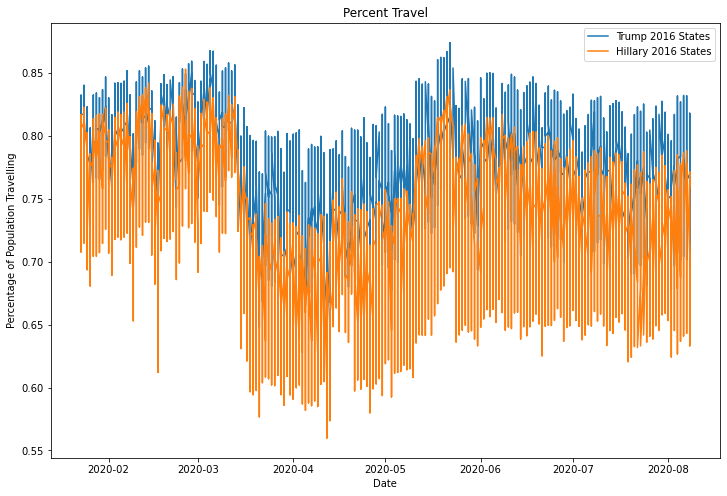

In [10]:
plt.figure(figsize=(12, 8))
#Plots for Percent Travel
x1 = results_df[results_df.state_code.isin(TRUMP_2016_STATES)].date
y1 = results_df[results_df.state_code.isin(TRUMP_2016_STATES)].Percent_Travel

plt.plot(x1, y1, label = 'Trump 2016 States')

x2 = results_df[results_df.state_code.isin(HILLARY_2016_STATES)].date
y2 = results_df[results_df.state_code.isin(HILLARY_2016_STATES)].Percent_Travel

plt.plot(x2, y2, label = 'Hillary 2016 States')


plt.xlabel('Date')
plt.ylabel('Percentage of Population Travelling')
plt.title('Percent Travel')
plt.legend()
plt.show()


## Group data by Date - Daily Average

In [11]:
#Split up the Trump and Hillary states
trump_states_df = results_df[results_df.state_code.isin(TRUMP_2016_STATES)]
hillary_states_df = results_df[results_df.state_code.isin(HILLARY_2016_STATES)]

#Group all Trump 2016 and Hillary 2016 states and get mean values
trump_mean_df = trump_states_df.groupby('date').mean().reset_index()
hillary_mean_df = hillary_states_df.groupby('date').mean().reset_index()

## Mean Percent Travel: Daily Average over Trump vs Hillary States
- Explore Mean Percent Travel
- Explore Difference in Means - check for significance..

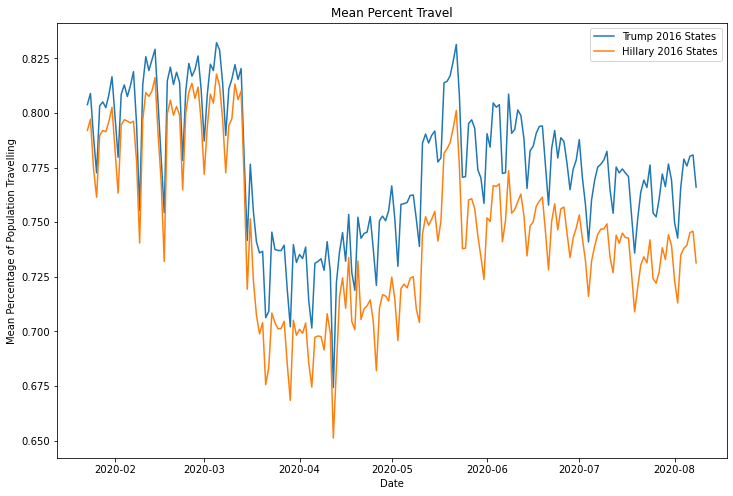

In [12]:
#Plot the mean Percent Travel grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_mean_df.date
y1 = trump_mean_df.Percent_Travel

plt.plot(x1, y1, label = 'Trump 2016 States')

x2 = hillary_mean_df.date
y2 =  hillary_mean_df.Percent_Travel
plt.plot(x2, y2, label = 'Hillary 2016 States')


plt.xlabel('Date')
plt.ylabel('Mean Percentage of Population Travelling')
plt.title('Mean Percent Travel')
plt.legend()
plt.show()

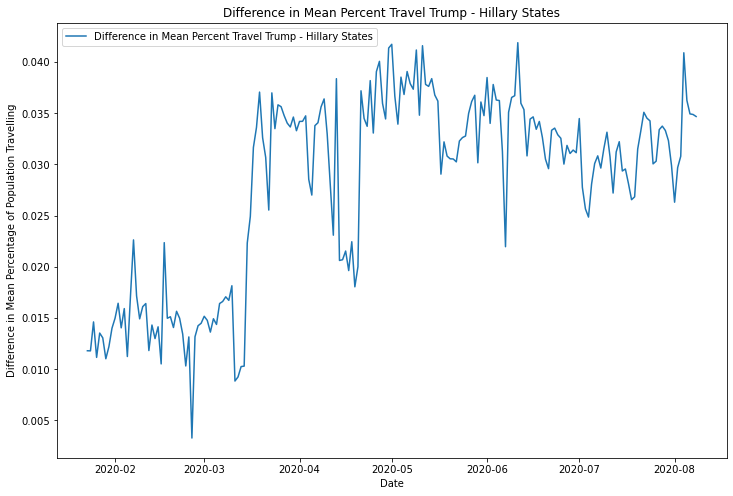

In [13]:
#Plot the difference between mean Percent Travel grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_mean_df.date
y1 = trump_mean_df.Percent_Travel - hillary_mean_df.Percent_Travel

plt.plot(x1, y1, label = 'Difference in Mean Percent Travel Trump - Hillary States')

plt.xlabel('Date')
plt.ylabel('Difference in Mean Percentage of Population Travelling')
plt.title('Difference in Mean Percent Travel Trump - Hillary States')
plt.legend()
plt.show()

## Average Trips per Person: Daily Average over Trump vs Hillary 2016 States
- Explore Mean Trips per Person
- Explore Difference in Means - check for significance..

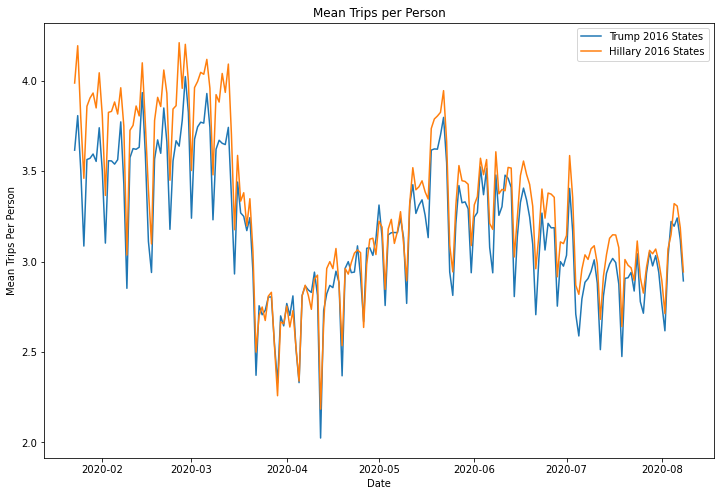

In [14]:
#Plot the mean Trips/person grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_mean_df.date
y1 = trump_mean_df.Trips_per_Person

plt.plot(x1, y1, label = 'Trump 2016 States')

x2 = hillary_mean_df.date
y2 =  hillary_mean_df.Trips_per_Person
plt.plot(x2, y2, label = 'Hillary 2016 States')


plt.xlabel('Date')
plt.ylabel('Mean Trips Per Person')
plt.title('Mean Trips per Person')
plt.legend()
plt.show()

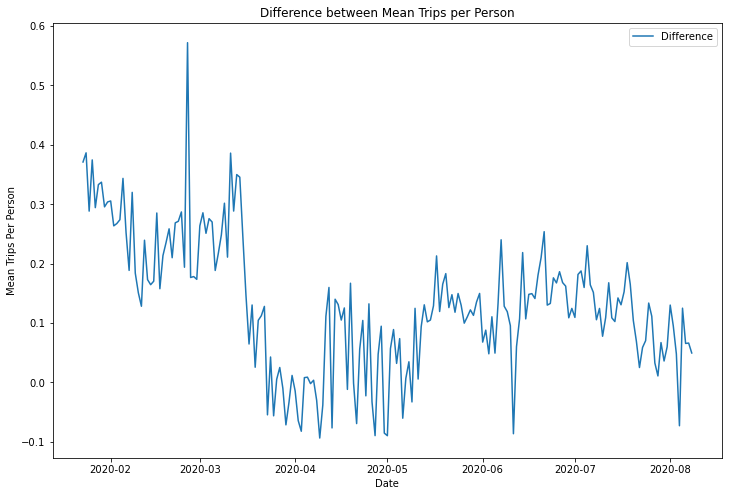

In [15]:
#Plot the mean Trips/person grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_mean_df.date
y1 = hillary_mean_df.Trips_per_Person - trump_mean_df.Trips_per_Person

plt.plot(x1, y1, label = 'Difference')


plt.xlabel('Date')
plt.ylabel('Mean Trips Per Person')
plt.title('Difference between Mean Trips per Person')
plt.legend()
plt.show()

## Mean Trips >25mi per Person: Daily Average over Trump vs Hillary States
- Look at Trips >25mi per Person
- Explore Difference in Means - check for significance..

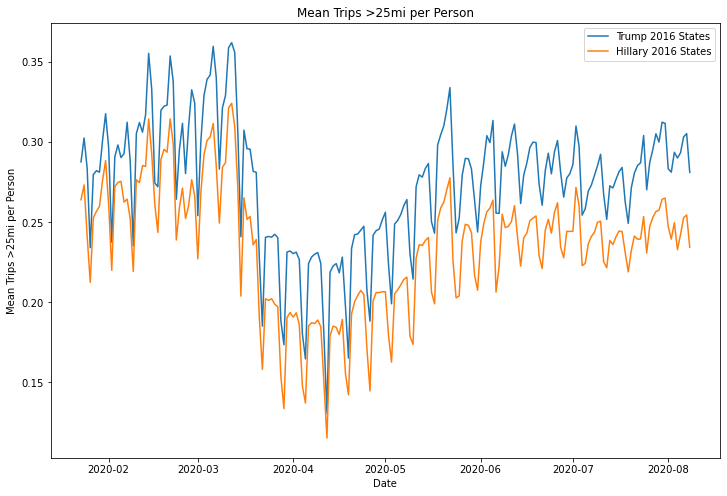

In [16]:
#Plot the mean Trips<25mi/person grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_mean_df.date
y1 = trump_mean_df['Trips>25mi_per_person']

plt.plot(x1, y1, label = 'Trump 2016 States')

x2 = hillary_mean_df.date
y2 =  hillary_mean_df['Trips>25mi_per_person']
plt.plot(x2, y2, label = 'Hillary 2016 States')


plt.xlabel('Date')
plt.ylabel('Mean Trips >25mi per Person')
plt.title('Mean Trips >25mi per Person')
plt.legend()
plt.show()

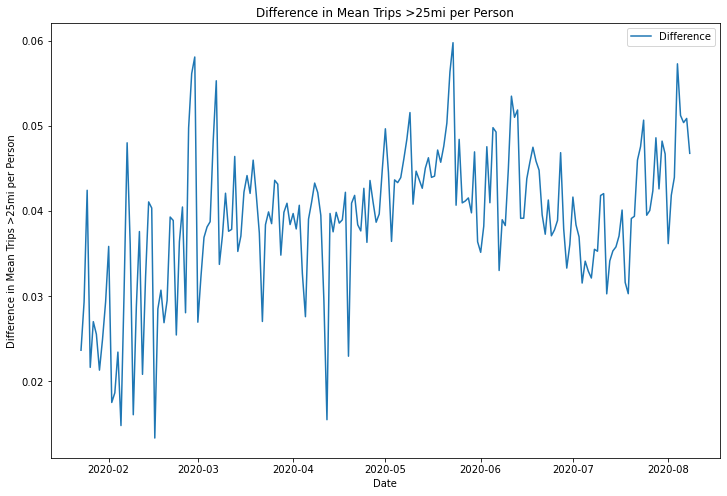

In [17]:
#Plot the mean Trips<25mi/person grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_mean_df.date
y1 = trump_mean_df['Trips>25mi_per_person'] - hillary_mean_df['Trips>25mi_per_person']

plt.plot(x1, y1, label = 'Difference')

plt.xlabel('Date')
plt.ylabel('Difference in Mean Trips >25mi per Person')
plt.title('Difference in Mean Trips >25mi per Person')
plt.legend()
plt.show()

### Run Students T-Test on the Percent Travel, Trips per Person & Trips >25mi
- This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. 

In [18]:
#Percent Travel
stats.ttest_ind(trump_mean_df.Percent_Travel, hillary_mean_df.Percent_Travel)

Ttest_indResult(statistic=8.080300757217168, pvalue=7.898522825017511e-15)

In [19]:
#Trips_per_Person
stats.ttest_ind(trump_mean_df.Trips_per_Person, hillary_mean_df.Trips_per_Person)

Ttest_indResult(statistic=-3.207216735386005, pvalue=0.001449187882418624)

In [20]:
#Trips >25mi
stats.ttest_ind(trump_mean_df['Trips>25mi_per_person'], hillary_mean_df['Trips>25mi_per_person'])

Ttest_indResult(statistic=9.875147738955702, pvalue=1.0475173984627022e-20)

In [21]:
#Trips <25mi
stats.ttest_ind(trump_mean_df['Trips<25mi_per_person'], hillary_mean_df['Trips<25mi_per_person'])

Ttest_indResult(statistic=-4.511398197943475, pvalue=8.499824059469572e-06)

## 7-Day Moving Average Analysis

In [22]:
#Use the rolling window to calculate the 7-day moving average
trump_7day_avg_df = trump_states_df.groupby('date').mean().reset_index()
trump_7day_avg_df.set_index('date', inplace=True)

hillary_7day_avg_df = hillary_states_df.groupby('date').mean().reset_index()
hillary_7day_avg_df.set_index('date', inplace=True)


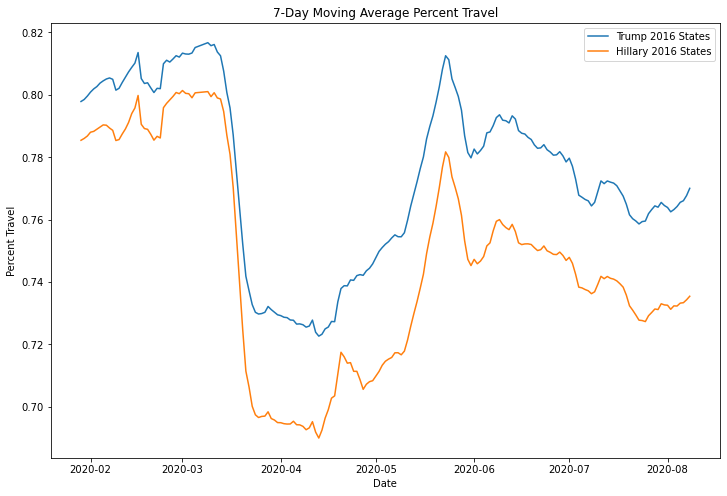

In [23]:
#Plot the mean Trips<25mi/person grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_7day_avg_df.index
y1 = trump_7day_avg_df['Percent_Travel'].rolling(window=7).mean()

plt.plot(x1, y1, label = 'Trump 2016 States')

x2 = hillary_7day_avg_df.index
y2 = hillary_7day_avg_df['Percent_Travel'].rolling(window=7).mean()
plt.plot(x2, y2, label = 'Hillary 2016 States')


plt.xlabel('Date')
plt.ylabel('Percent Travel')
plt.title('7-Day Moving Average Percent Travel')
plt.legend()
plt.show()

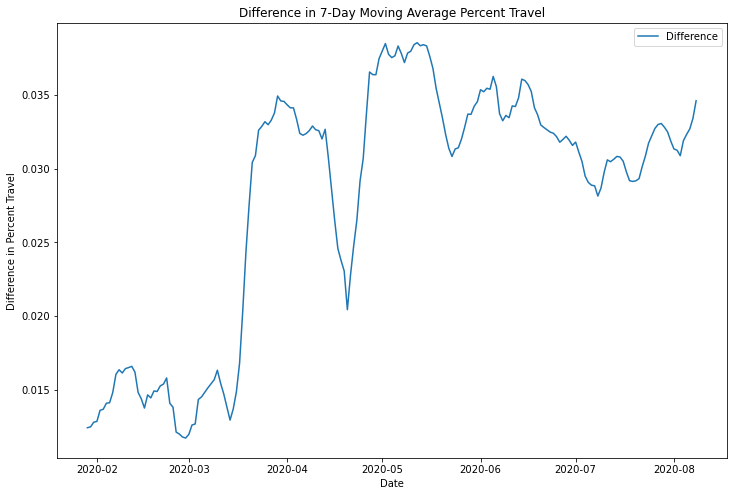

In [24]:
#Plot the mean Trips<25mi/person grouped by TRUMP vs HILLARY states and by date
plt.figure(figsize=(12, 8))

x1 = trump_7day_avg_df.index
y1 = trump_7day_avg_df['Percent_Travel'].rolling(window=7).mean() - hillary_7day_avg_df['Percent_Travel'].rolling(window=7).mean()

plt.plot(x1, y1, label = 'Difference')


plt.xlabel('Date')
plt.ylabel('Difference in Percent Travel')
plt.title('Difference in 7-Day Moving Average Percent Travel')
plt.legend()


In [25]:
#T-test for comparison of means
stats.ttest_ind(trump_7day_avg_df['Percent_Travel'].rolling(window=7).mean()[6:], 
                hillary_7day_avg_df['Percent_Travel'].rolling(window=7).mean()[6:])

Ttest_indResult(statistic=8.81316051923435, pvalue=4.272909973150783e-17)

## Related Research Papers
- The COVID-19 Pandemic, Community Mobility and the Effectiveness of Nonpharmaceutical Interventions: The United States of America, February to May 2020 https://arxiv.org/ftp/arxiv/papers/2007/2007.12644.pdf
- COVID-19 in the United States: Trajectories and second surge behavior https://arxiv.org/pdf/2008.02068.pdf
- Markovian And Non-Markovian Processes with Active Decision Making Strategies For Addressing The COVID-19 Pandemic https://arxiv.org/pdf/2008.00375.pdf
- DoT Analysis: https://www.bts.gov/browse-statistical-products-and-data/trips-distance/daily-travel-during-covid-19-pandemic
- Mining Google and Apple mobility data: Twenty-one shades of European social distancing measures for COVID-19 https://arxiv.org/pdf/2008.02117.pdf
- Tracking the Spread of COVID-19 with Air Travel Data https://www.rand.org/nsrd/projects/cat-v.html
- 

## New Data Sources:
- https://www.kff.org/coronavirus-covid-19/issue-brief/state-data-and-policy-actions-to-address-coronavirus/
- https://www.nytimes.com/interactive/2020/us/coronavirus-spread.html

## Time Series Analysis of JHU Covid Data

In [26]:
#Specify file paths
daily_reports_path="/Users/kvomb/Documents/KV Projects/Covid19/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/"
time_series_path="/Users/kvomb/Documents/KV Projects/Covid19/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

In [27]:
#glob.glob(daily_reports_path+"*")

In [28]:
#Read in recent data
#jul28 = pd.read_csv(daily_reports_path+"08-16-2020.csv")

## Extract State Code Data

In [29]:
state_code_string = '''AK	Alaska
AL	Alabama
AR	Arkansas
AZ	Arizona
CA	California
CO	Colorado
CT	Connecticut
DC	District of Columbia
DE	Delaware
FL	Florida
GA	Georgia
HI	Hawaii
IA	Iowa
ID	Idaho
IL	Illinois
IN	Indiana
KS	Kansas
KY	Kentucky
LA	Louisiana
MA	Massachusetts
MD	Maryland
ME	Maine
MI	Michigan
MN	Minnesota
MO	Missouri
MS	Mississippi
MT	Montana
NC	North Carolina
ND	North Dakota
NE	Nebraska
NH	New Hampshire
NJ	New Jersey
NM	New Mexico
NV	Nevada
NY	New York
OH	Ohio
OK	Oklahoma
OR	Oregon
PA	Pennsylvania
RI	Rhode Island
SC	South Carolina
SD	South Dakota
TN	Tennessee
TX	Texas
UT	Utah
VA	Virginia
VT	Vermont
WA	Washington
WI	Wisconsin
WV	West Virginia
WY	Wyoming'''

In [30]:
STATE_CODE_DICT = {}
for code_state_pair in state_code_string.split('\n'):
    state_name = code_state_pair.split("\t")[1]
    state_code = code_state_pair.split("\t")[0]
    STATE_CODE_DICT[state_name] = state_code

In [661]:
with open('StateCodes_dict.json', 'w') as fp:
    json.dump(STATE_CODE_DICT, fp)

In [667]:
with open('StateCodes_dict.json', 'r') as fp:
    dict_1 = json.load(fp)

In [668]:
dict_1

{'Alaska': 'AK',
 'Alabama': 'AL',
 'Arkansas': 'AR',
 'Arizona': 'AZ',
 'California': 'CA',
 'Colorado': 'CO',
 'Connecticut': 'CT',
 'District of Columbia': 'DC',
 'Delaware': 'DE',
 'Florida': 'FL',
 'Georgia': 'GA',
 'Hawaii': 'HI',
 'Iowa': 'IA',
 'Idaho': 'ID',
 'Illinois': 'IL',
 'Indiana': 'IN',
 'Kansas': 'KS',
 'Kentucky': 'KY',
 'Louisiana': 'LA',
 'Massachusetts': 'MA',
 'Maryland': 'MD',
 'Maine': 'ME',
 'Michigan': 'MI',
 'Minnesota': 'MN',
 'Missouri': 'MO',
 'Mississippi': 'MS',
 'Montana': 'MT',
 'North Carolina': 'NC',
 'North Dakota': 'ND',
 'Nebraska': 'NE',
 'New Hampshire': 'NH',
 'New Jersey': 'NJ',
 'New Mexico': 'NM',
 'Nevada': 'NV',
 'New York': 'NY',
 'Ohio': 'OH',
 'Oklahoma': 'OK',
 'Oregon': 'OR',
 'Pennsylvania': 'PA',
 'Rhode Island': 'RI',
 'South Carolina': 'SC',
 'South Dakota': 'SD',
 'Tennessee': 'TN',
 'Texas': 'TX',
 'Utah': 'UT',
 'Virginia': 'VA',
 'Vermont': 'VT',
 'Washington': 'WA',
 'Wisconsin': 'WI',
 'West Virginia': 'WV',
 'Wyoming': 'WY

In [32]:
#Read in Time Series data
US_confirmed_TS = pd.read_csv(time_series_path+"time_series_covid19_confirmed_US.csv")

In [33]:
US_confirmed_TS.Province_State.value_counts()

Texas                       256
Georgia                     161
Virginia                    135
Kentucky                    122
Missouri                    118
Kansas                      107
Illinois                    104
North Carolina              102
Iowa                        101
Tennessee                    97
Nebraska                     95
Indiana                      94
Ohio                         90
Minnesota                    89
Michigan                     87
Mississippi                  84
Puerto Rico                  80
Oklahoma                     79
Arkansas                     77
Wisconsin                    74
Florida                      69
Pennsylvania                 69
Alabama                      69
South Dakota                 68
Colorado                     66
Louisiana                    66
New York                     64
California                   60
Montana                      58
West Virginia                57
North Dakota                 55
South Ca

In [34]:
US_confirmed_TS[US_confirmed_TS.Province_State == "Massachusetts"]

UID iso2 iso3  code3     FIPS               Admin2 Province_State  \
1263  84025001   US  USA    840  25001.0           Barnstable  Massachusetts   
1264  84025003   US  USA    840  25003.0            Berkshire  Massachusetts   
1265  84025005   US  USA    840  25005.0              Bristol  Massachusetts   
1266  84025007   US  USA    840  25007.0                Dukes  Massachusetts   
1267  84070002   US  USA    840      NaN  Dukes and Nantucket  Massachusetts   
1268  84025009   US  USA    840  25009.0                Essex  Massachusetts   
1269  84025011   US  USA    840  25011.0             Franklin  Massachusetts   
1270  84025013   US  USA    840  25013.0              Hampden  Massachusetts   
1271  84025015   US  USA    840  25015.0            Hampshire  Massachusetts   
1272  84025017   US  USA    840  25017.0            Middlesex  Massachusetts   
1273  84025019   US  USA    840  25019.0            Nantucket  Massachusetts   
1274  84025021   US  USA    840  25021.0              Norfolk  Massachusetts   
1275  84080025   US  USA    840  80025.0            Out of MA  Massachusetts   
1276  84025023   US  USA    840  25023.0             Plymouth  Massachusetts   
1277  84025025   US  USA    840  25025.0              Suffolk  Massachusetts   
1278  84090025   US  USA    840  90025.0           Unassigned  Massachusetts   
1279  84025027   US  USA    840  25027.0            Worcester  Massachusetts   

     Country_Region        Lat      Long_  \
1263             US  41.729806 -70.288543   
1264             US  42.374284 -73.205248   
1265             US  41.792284 -71.108722   
1266             US  41.406747 -70.687635   
1267             US  41.406747 -70.687635   
1268             US  42.668763 -70.946872   
1269             US  42.581197 -72.586025   
1270             US  42.134404 -72.632356   
1271             US  42.339980 -72.658985   
1272             US  42.486077 -71.390492   
1273             US  41.294202 -70.087747   
1274             US  42.160731 -71.205304   
1275             US   0.000000   0.000000   
1276             US  41.940706 -70.808028   
1277             US  42.327951 -71.078504   
1278             US   0.000000   0.000000   
1279             US  42.350270 -71.904934   

                              Combined_Key  1/22/20  1/23/20  1/24/20  \
1263         Barnstable, Massachusetts, US        0        0        0   
1264          Berkshire, Massachusetts, US        0        0        0   
1265            Bristol, Massachusetts, US        0        0        0   
1266              Dukes, Massachusetts, US        0        0        0   
1267  Dukes and Nantucket,Massachusetts,US        0        0        0   
1268              Essex, Massachusetts, US        0        0        0   
1269           Franklin, Massachusetts, US        0        0        0   
1270            Hampden, Massachusetts, US        0        0        0   
1271          Hampshire, Massachusetts, US        0        0        0   
1272          Middlesex, Massachusetts, US        0        0        0   
1273          Nantucket, Massachusetts, US        0        0        0   
1274            Norfolk, Massachusetts, US        0        0        0   
1275          Out of MA, Massachusetts, US        0        0        0   
1276           Plymouth, Massachusetts, US        0        0        0   
1277            Suffolk, Massachusetts, US        0        0        0   
1278         Unassigned, Massachusetts, US        0        0        0   
1279          Worcester, Massachusetts, US        0        0        0   

      1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  \
1263        0        0        0        0        0        0        0       0   
1264        0        0        0        0        0        0        0       0   
1265        0        0        0        0        0        0        0       0   
1266        0        0        0        0        0        0        0       0   
1267        0        0        0        0        0

In [35]:
US_confirmed_TS.columns[11:]

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '8/11/20', '8/12/20', '8/13/20', '8/14/20', '8/15/20', '8/16/20',
       '8/17/20', '8/18/20', '8/19/20', '8/20/20'],
      dtype='object', length=212)

In [36]:
#Group by state
State_Cases = US_confirmed_TS.groupby(['Province_State'])[US_confirmed_TS.columns[11:]].sum().reset_index()

In [37]:
#Sort by most to least cases
State_Cases.sort_values(by=[State_Cases.columns[-1]], inplace=True, ascending=False)

#Convert states to codes and keep only 51
State_Cases.replace(STATE_CODE_DICT, inplace=True)

State_Cases = State_Cases[State_Cases['Province_State'].isin(STATE_CODE_DICT.values())].reset_index(drop=True)

State_Cases

Province_State  1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  \
0              CA        0        0        0        0        2        2   
1              FL        0        0        0        0        0        0   
2              TX        0        0        0        0        0        0   
3              NY        0        0        0        0        0        0   
4              GA        0        0        0        0        0        0   
5              IL        0        0        1        1        1        1   
6              AZ        0        0        0        0        1        1   
7              NJ        0        0        0        0        0        0   
8              NC        0        0        0        0        0        0   
9              LA        0        0        0        0        0        0   
10             TN        0        0        0        0        0        0   
11             PA        0        0        0        0        0        0   
12             MA        0        0        0        0        0        0   
13             AL        0        0        0        0        0        0   
14             OH        0        0        0        0        0        0   
15             VA        0        0        0        0        0        0   
16             SC        0        0        0        0        0        0   
17             MI        0        0        0        0        0        0   
18             MD        0        0        0        0        0        0   
19             IN        0        0        0        0        0        0   
20             MS        0        0        0        0        0        0   
21             MO        0        0        0        0        0        0   
22             WA        1        1        1        1        1        1   
23             WI        0        0        0        0        0        0   
24             MN        0        0        0        0        0        0   
25             NV        0        0        0        0        0        0   
26             AR        0        0        0        0        0        0   
27             IA        0        0        0        0        0        0   
28             CO        0        0        0        0        0        0   
29             CT        0        0        0        0        0        0   
30             OK        0        0        0        0        0        0   
31             UT        0        0        0        0        0        0   
32             KY        0        0        0        0        0        0   
33             KS        0        0        0        0        0        0   
34             NE        0        0        0        0        0        0   
35             ID        0        0        0        0        0        0   
36             OR        0        0        0        0        0        0   
37             NM        0        0        0        0        0        0   
38             RI        0        0        0        0        0        0   
39             DE        0        0        0        0        0        0   
40             DC        0        0        0        0        0        0   
41             SD        0        0        0        0        0        0   
42             ND        0        0        0        0        0        0   
43             WV        0        0        0        0        0        0   
44             NH        0        0        0        0        0        0   
45             MT        0        0        0        0        0        0   
46             HI        0        0        0        0        0        0   
47             AK        0        0        0        0        0        0   
48             ME        0        0        0        0        0        0   
49             WY        0        0        0        0        0        0   
50             VT        0        0        0        0        0        0   

    1/28/20  1/29/20  1/30/20  1/31/20  2/1/20  2/2/20  2/3/20  2/4/20  \
0         2        2        

In [38]:
#Total cases
State_Cases[State_Cases.columns[-1]].sum()

5543925

In [39]:
#Transpose to get each state as a column time-series
State_Cases_transposed = State_Cases.T
State_Cases_transposed.columns = State_Cases_transposed.iloc[0]
State_Cases_transposed = State_Cases_transposed[1:]

In [40]:
#Set the Date as the index
State_Cases_transposed['Date'] = pd.to_datetime(State_Cases_transposed.index)
State_Cases_transposed.reset_index(drop=True, inplace=True)
State_Cases_transposed.columns.name = 'States'
State_Cases_transposed.set_index('Date', inplace=True)

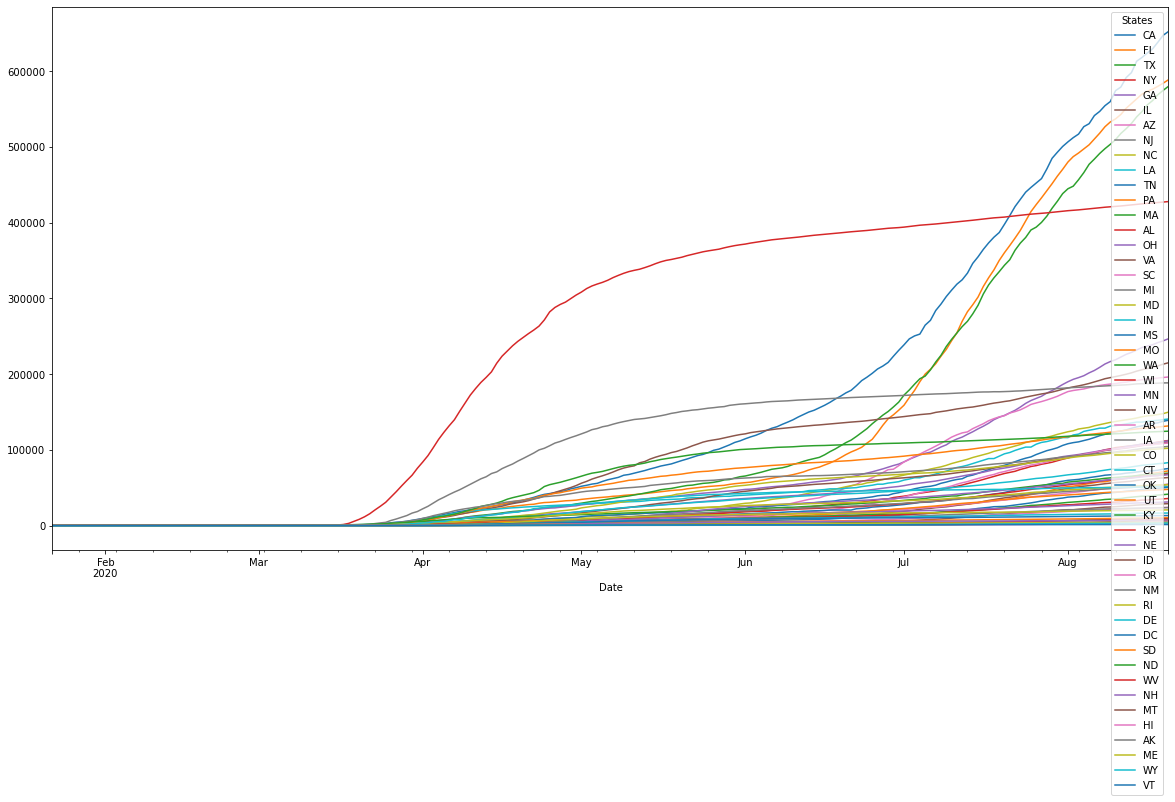

In [41]:
State_Cases_transposed.plot(figsize=(20,10))
#linePlot = State_Cases_transposed[1:].plot.line()

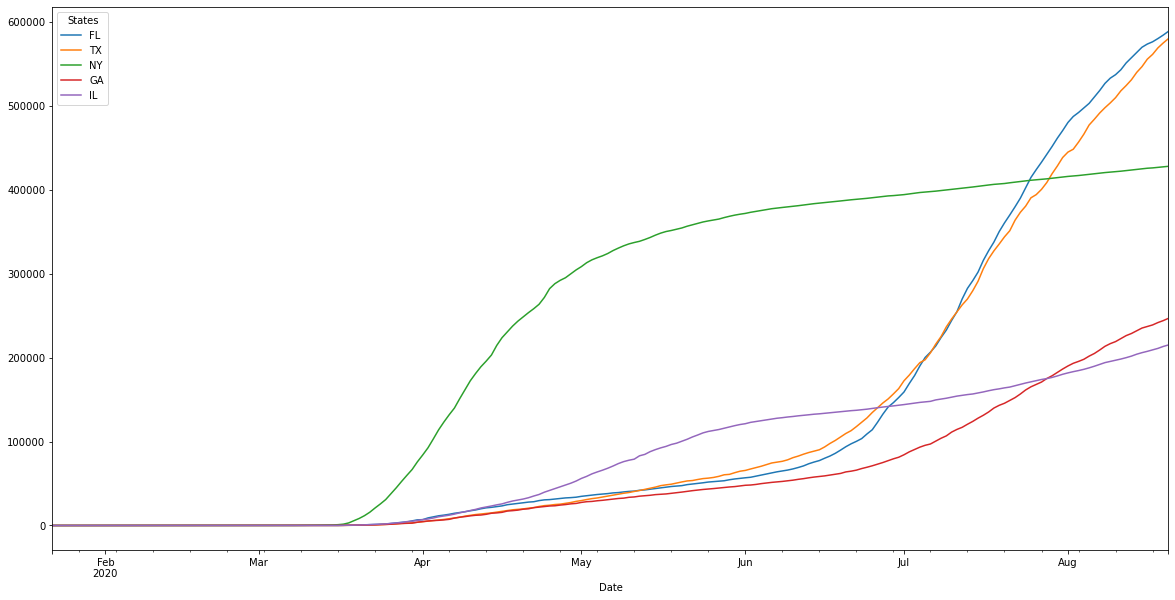

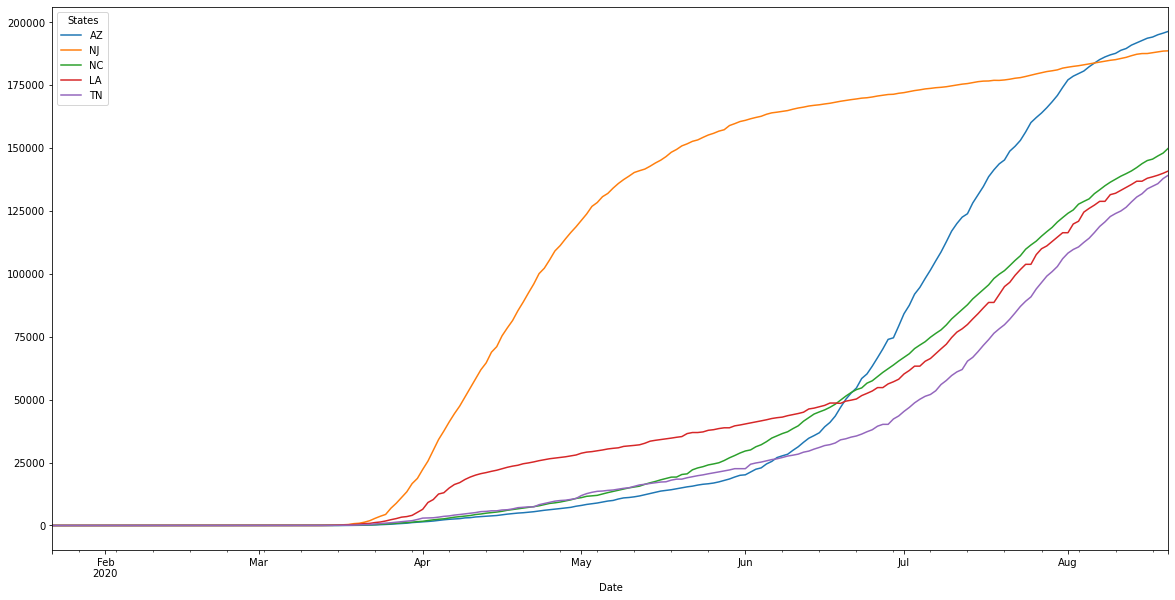

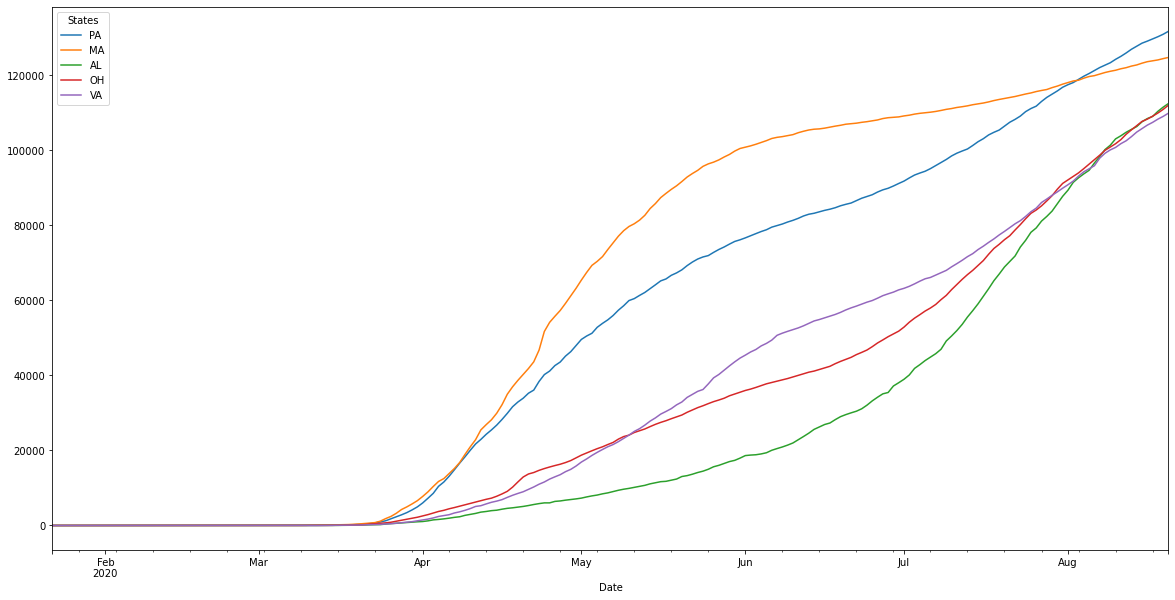

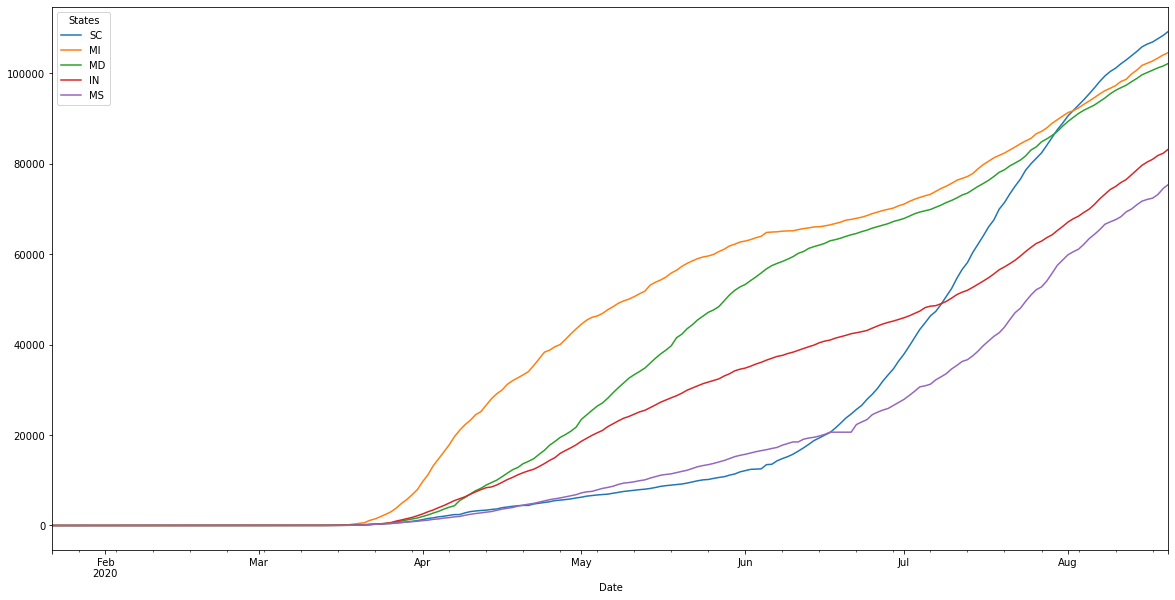

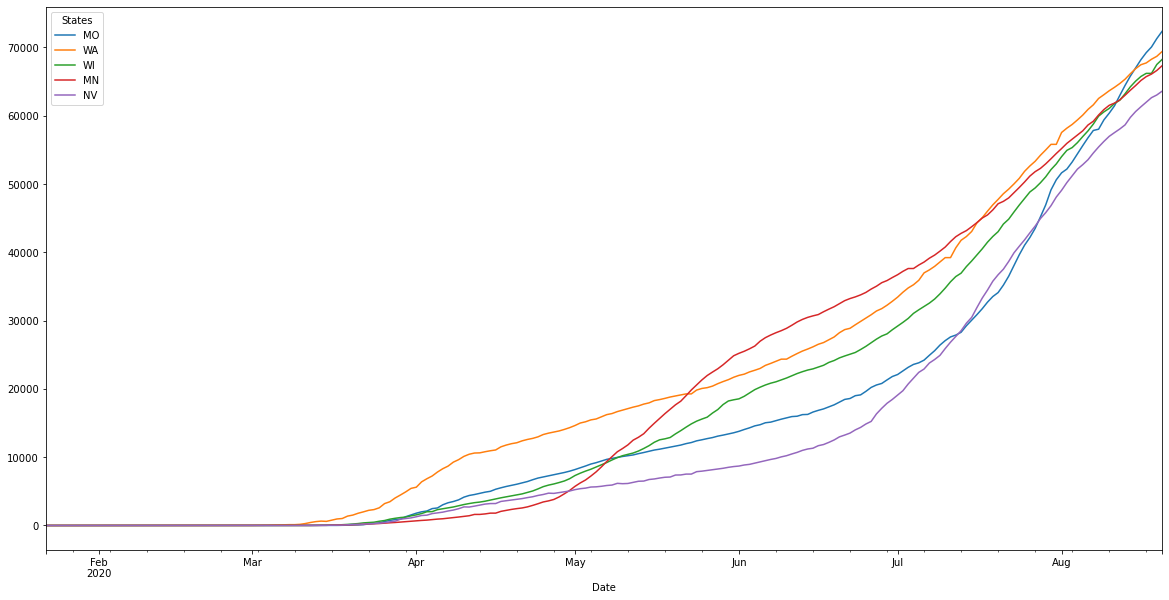

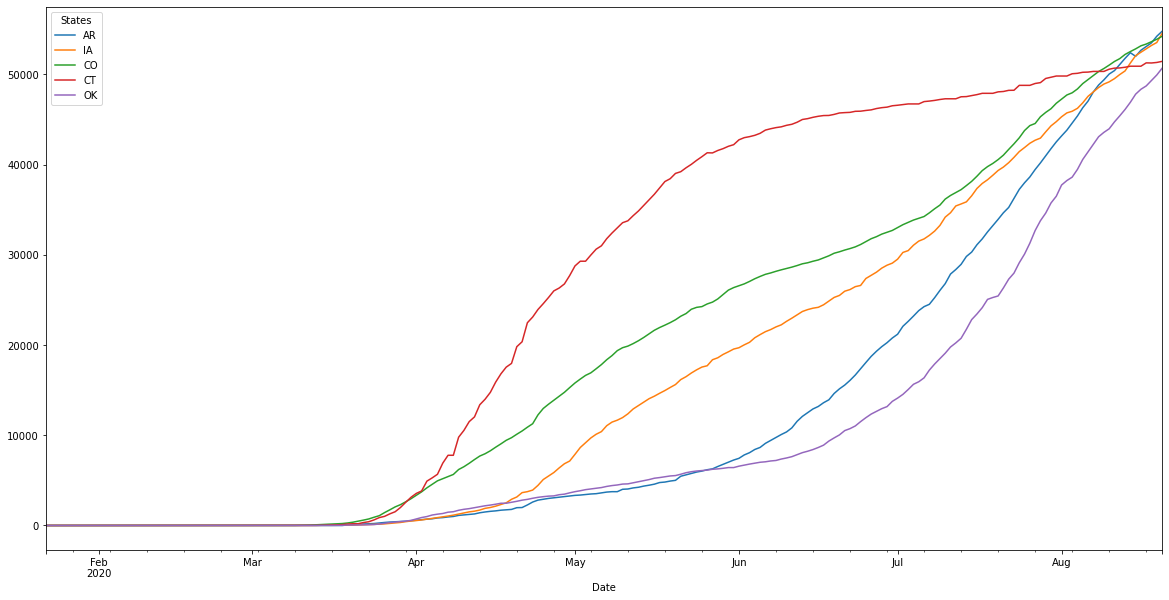

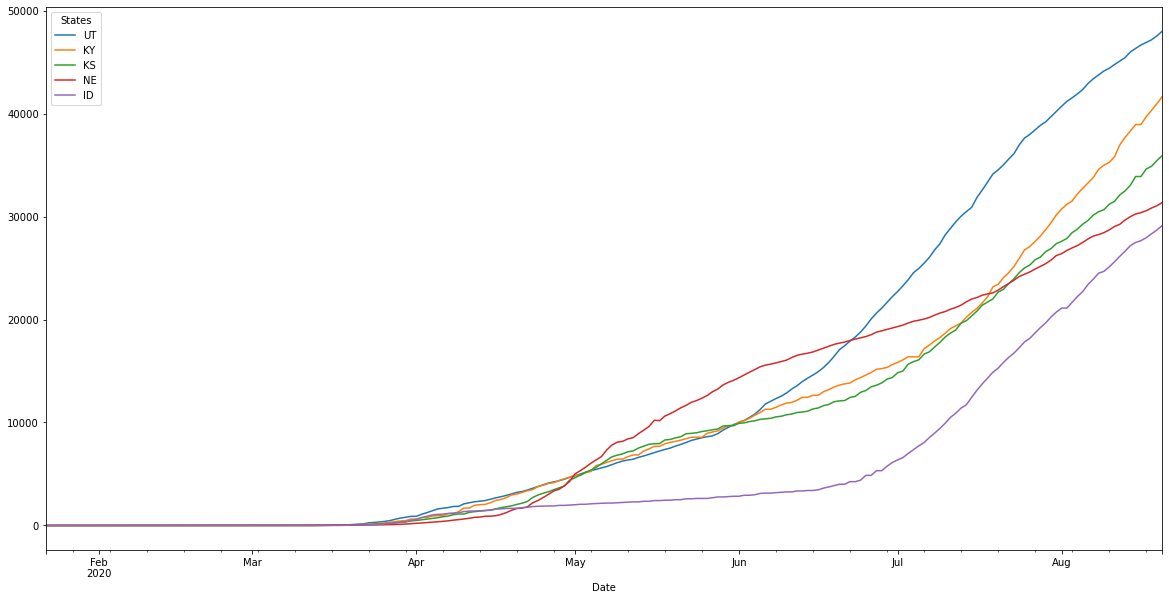

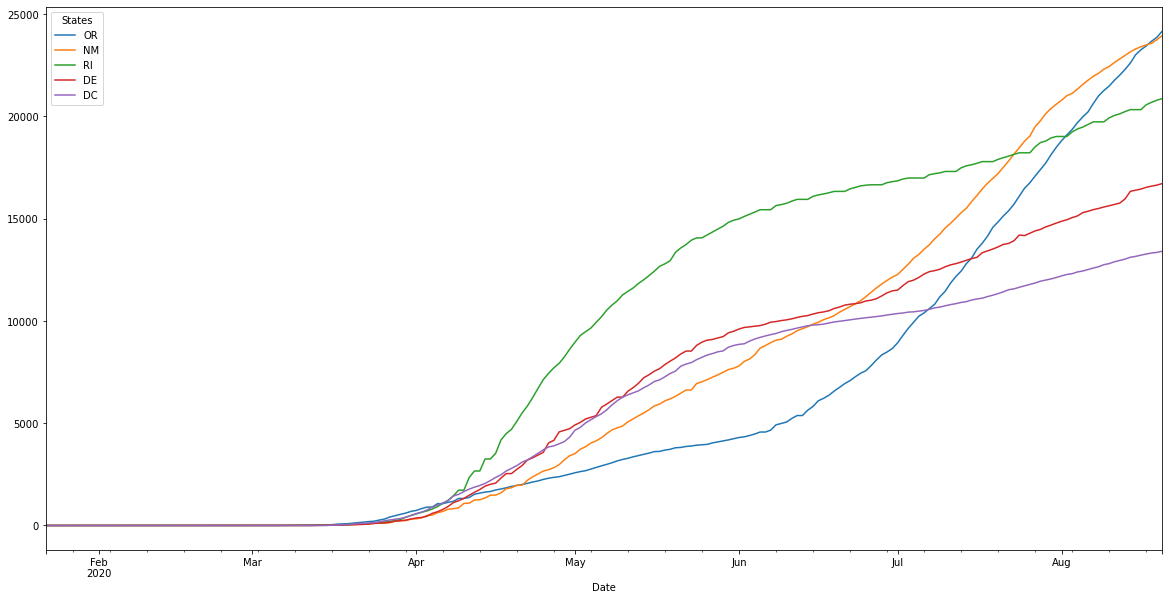

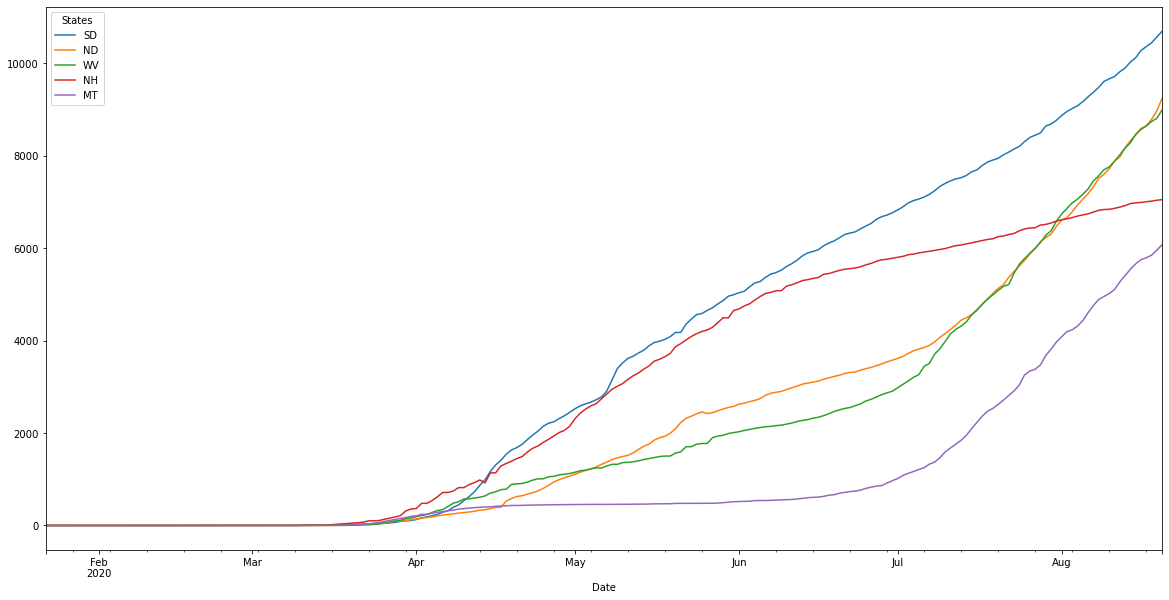

In [42]:
#Plot groups of 5 neighboring states
for i in range(1, 45, 5):
    State_Cases_transposed[State_Cases_transposed.columns[i:i+5]].plot(figsize=(20,10))

In [ ]:
##Normalized Plots

In [ ]:
normalized_df=(State_Cases_transposed-State_Cases_transposed.min())/(State_Cases_transposed.max()-State_Cases_transposed.min())

In [ ]:
for i in range(0, 45, 5):
    normalized_df[normalized_df.columns[i:i+5]].plot(figsize=(20,10))

In [ ]:
## Examine Growth Rate by State

#Test function for exponential growth with rate r, time t days
def exponential_function(x_0, r, t):
    x_t_list = [x_0] #Initialize with x_0
    for i in range(t+1):
        x_t = x_t_list[i]*(1+r)
        x_t_list.append(x_t)
        
    return x_t_list

In [ ]:
exponential_function(5, .2, 10)

In [ ]:
5*np.exp(1.8)

## Get the Population and Land Area to Cluster States
- Data from US Census

In [43]:
US_STATE_POPULATION_DICT = {'Alabama':4903185, 'Alaska':731545,'Arizona':7278717,'Arkansas':3017804,'California':39512223,
                            'Colorado':5758736,'Connecticut':3565287,'Delaware':973764,'District of Columbia':705749,
                            'Florida':21477737,'Georgia':10617423,'Hawaii':1415872,'Idaho':1787065,'Illinois':12671821,
                            'Indiana':6732219,'Iowa':3155070,'Kansas':2913314,'Kentucky':4467673,'Louisiana':4648794,
                            'Maine':1344212,'Maryland':6045680,'Massachusetts':6892503,'Michigan':9986857,
                            'Minnesota':5639632,'Mississippi':2976149,'Missouri':6137428,'Montana':1068778,
                            'Nebraska':1934408,'Nevada':3080156,'New Hampshire':1359711,'New Jersey':8882190,
                            'New Mexico':2096829,'New York':19453561,'North Carolina':10488084,'North Dakota':762062,
                            'Ohio':11689100,'Oklahoma':3956971,'Oregon':4217737,'Pennsylvania':12801989,
                            'Rhode Island':1059361,'South Carolina':5148714,'South Dakota':884659,'Tennessee':6829174,
                            'Texas':28995881,'Utah':3205958,'Vermont':623989,'Virginia':8535519,'Washington':7614893, 
                            'West Virginia':1792147,'Wisconsin':5822434,'Wyoming':578759}

In [44]:
land_area_str = '''State	Value
Alabama	50,645.33
Alaska	570,640.95
Arizona	113,594.08
Arkansas	52,035.48
California	155,779.22
Colorado	103,641.89
Connecticut	4,842.36
Delaware	1,948.54
District of Columbia	61.05
Florida	53,624.76
Georgia	57,513.49
Hawaii	6,422.63
Idaho	82,643.12
Illinois	55,518.93
Indiana	35,826.11
Iowa	55,857.13
Kansas	81,758.72
Kentucky	39,486.34
Louisiana	43,203.90
Maine	30,842.92
Maryland	9,707.24
Massachusetts	7,800.06
Michigan	56,538.90
Minnesota	79,626.74
Mississippi	46,923.27
Missouri	68,741.52
Montana	145,545.80
Nebraska	76,824.17
Nevada	109,781.18
New Hampshire	8,952.65
New Jersey	7,354.22
New Mexico	121,298.15
New York	47,126.40
North Carolina	48,617.91
North Dakota	69,000.80
Ohio	40,860.69
Oklahoma	68,594.92
Oregon	95,988.01
Pennsylvania	44,742.70
Rhode Island	1,033.81
South Carolina	30,060.70
South Dakota	75,811.00
Tennessee	41,234.90
Texas	261,231.71
Utah	82,169.62
Vermont	9,216.66
Virginia	39,490.09
Washington	66,455.52
West Virginia	24,038.21
Wisconsin	54,157.80
Wyoming	97,093.14'''

In [45]:
US_LAND_AREA_DICT = {}
for state_area_pair in land_area_str.split('\n')[1:]:
    state_name = state_area_pair.split("\t")[0]
    land_area = float(state_area_pair.split("\t")[1].replace(",", ""))
    US_LAND_AREA_DICT[state_name] = land_area

In [46]:
US_LAND_AREA_DICT

{'Alabama': 50645.33,
 'Alaska': 570640.95,
 'Arizona': 113594.08,
 'Arkansas': 52035.48,
 'California': 155779.22,
 'Colorado': 103641.89,
 'Connecticut': 4842.36,
 'Delaware': 1948.54,
 'District of Columbia': 61.05,
 'Florida': 53624.76,
 'Georgia': 57513.49,
 'Hawaii': 6422.63,
 'Idaho': 82643.12,
 'Illinois': 55518.93,
 'Indiana': 35826.11,
 'Iowa': 55857.13,
 'Kansas': 81758.72,
 'Kentucky': 39486.34,
 'Louisiana': 43203.9,
 'Maine': 30842.92,
 'Maryland': 9707.24,
 'Massachusetts': 7800.06,
 'Michigan': 56538.9,
 'Minnesota': 79626.74,
 'Mississippi': 46923.27,
 'Missouri': 68741.52,
 'Montana': 145545.8,
 'Nebraska': 76824.17,
 'Nevada': 109781.18,
 'New Hampshire': 8952.65,
 'New Jersey': 7354.22,
 'New Mexico': 121298.15,
 'New York': 47126.4,
 'North Carolina': 48617.91,
 'North Dakota': 69000.8,
 'Ohio': 40860.69,
 'Oklahoma': 68594.92,
 'Oregon': 95988.01,
 'Pennsylvania': 44742.7,
 'Rhode Island': 1033.81,
 'South Carolina': 30060.7,
 'South Dakota': 75811.0,
 'Tennessee'

In [670]:
with open('StateArea_dict.json', 'w') as fp:
    json.dump(US_LAND_AREA_DICT, fp)

In [47]:
# State_Population_df = pd.DataFrame.from_dict(US_STATE_POPULATION_AREA_DICT, orient='index', 
#                        columns=['Population', 'Area']).reset_index().rename(columns={'index':'State'})

In [48]:
State_Population_df = pd.DataFrame.from_dict(US_STATE_POPULATION_DICT, orient='index', 
                       columns=['Population']).reset_index().rename(columns={'index':'State'})
State_Area_df = pd.DataFrame.from_dict(US_LAND_AREA_DICT, orient='index', 
                       columns=['Area']).reset_index().rename(columns={'index':'State'})

In [49]:
State_Cluster_df = pd.merge(State_Population_df, State_Area_df, on='State', how='inner')

In [50]:
State_Cluster_df.replace(STATE_CODE_DICT, inplace=True)

In [51]:
State_Cluster_df['Pop_per_sqMile'] = State_Cluster_df.Population/State_Cluster_df.Area
State_Cluster_df[State_Cluster_df.columns[1:]] = (State_Cluster_df[State_Cluster_df.columns[1:]]-State_Cluster_df[State_Cluster_df.columns[1:]].min())/(State_Cluster_df[State_Cluster_df.columns[1:]].max()-State_Cluster_df[State_Cluster_df.columns[1:]].min())

In [52]:
State_Cluster_df

State  Population      Area  Pop_per_sqMile
0     AL    0.111072  0.088654        0.008265
1     AK    0.003924  1.000000        0.000000
2     AZ    0.172087  0.198978        0.005433
3     AR    0.062646  0.091091        0.004906
4     CA    1.000000  0.272912        0.021833
5     CO    0.133047  0.181536        0.004696
6     CT    0.076709  0.008380        0.063586
7     DE    0.010146  0.003308        0.043123
8     DC    0.003262  0.000000        1.000000
9     FL    0.536787  0.093876        0.034539
10    GA    0.257842  0.100691        0.015860
11    HI    0.021501  0.011149        0.018961
12    ID    0.031035  0.144734        0.001760
13    IL    0.310608  0.097196        0.019635
14    IN    0.158051  0.062682        0.016146
15    IA    0.066172  0.097788        0.004776
16    KS    0.059963  0.143184        0.002972
17    KY    0.099886  0.069097        0.009678
18    LA    0.104538  0.075612        0.009198
19    ME    0.019661  0.053948        0.003660
20    MD    0.140417  0.016906        0.053770
21    MA    0.162168  0.013563        0.076336
22    MI    0.241646  0.098983        0.015171
23    MN    0.129988  0.139447        0.006016
24    MS    0.061577  0.082131        0.005376
25    MO    0.142774  0.120370        0.007613
26    MT    0.012586  0.254977        0.000524
27    NE    0.034820  0.134535        0.002067
28    NV    0.064248  0.192296        0.002316
29    NH    0.020059  0.015583        0.013029
30    NJ    0.213272  0.012782        0.104377
31    NM    0.038991  0.212480        0.001385
32    NY    0.484796  0.082487        0.035601
33    NC    0.254519  0.085101        0.018552
34    ND    0.004708  0.120824        0.000845
35    OH    0.285367  0.071506        0.024638
36    OK    0.086769  0.120113        0.004880
37    OR    0.093467  0.168122        0.003691
38    PA    0.313952  0.078309        0.024643
39    RI    0.012344  0.001705        0.088541
40    SC    0.117379  0.052577        0.014707
41    SD    0.007857  0.132760        0.000899
42    TN    0.160541  0.072161        0.014217
43    TX    0.729889  0.457728        0.009492
44    UT    0.067479  0.143904        0.003265
45    VT    0.001162  0.016046        0.005746
46    VA    0.204368  0.069103        0.018588
47    WA    0.180722  0.116363        0.009802
48    WV    0.031166  0.042022        0.006339
49    WI    0.134683  0.094810        0.009190
50    WY    0.000000  0.170059        0.000405

### Use KMeans model to Cluster Red states and then apply same model to Blue states

In [53]:
#Split states by Political Lines
trump_state_cluster_df = State_Cluster_df[State_Cluster_df['State'].isin(TRUMP_2016_STATES)].reset_index(drop=True)
hillary_state_cluster_df = State_Cluster_df[State_Cluster_df['State'].isin(HILLARY_2016_STATES)].reset_index(drop=True)

#Keep track of state Red vs Blue in 2016 election
trump_state_cluster_df['Red'] = 1
hillary_state_cluster_df['Red'] = 0

In [54]:
k_values = [3,4,5,6,7,8,9,10]

In [55]:
#Use KMeans model to Cluster Red states and then apply same model to Blue states
inertia_vec=[]
for k in k_values:
    red_kmeans_model = KMeans(n_clusters=k, random_state=53412).fit(trump_state_cluster_df[['Population',
                                                                                        'Area', 'Pop_per_sqMile']])
    inertia_vec.append(red_kmeans_model.inertia_)

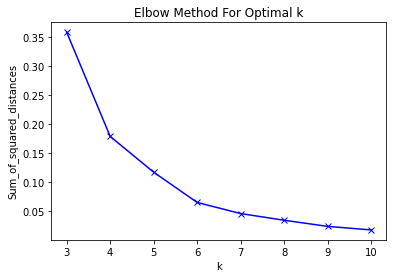

In [56]:
plt.plot(k_values, inertia_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [57]:
#Run model for best K=6 or 7 as of elbow method
best_k = 7
red_kmeans_model = KMeans(n_clusters=best_k, random_state=53412).fit(trump_state_cluster_df[['Population',
                                                                                        'Area', 'Pop_per_sqMile']])
trump_state_cluster_df['Cluster'] = red_kmeans_model.labels_

In [58]:
#Assign Cluster for Hillary States using red kmeans model
hillary_state_cluster_df['Cluster'] = red_kmeans_model.predict(hillary_state_cluster_df[['Population',
                                                                                        'Area', 'Pop_per_sqMile']])

In [59]:
red_kmeans_model.inertia_

0.045383941422398266

In [60]:
#Concatenate and Sort
states_clustered_df = pd.concat([hillary_state_cluster_df, trump_state_cluster_df], 
                                axis=0).sort_values(by='Cluster').reset_index(drop = True)

In [61]:
states_clustered_df.Cluster.value_counts()

0    18
5    11
6    10
3     7
4     2
2     2
1     1
Name: Cluster, dtype: int64

In [62]:
states_clustered_df.groupby('Cluster').Red.value_counts()

Cluster  Red
0        0      9
         1      9
1        1      1
2        0      1
         1      1
3        1      5
         0      2
4        0      1
         1      1
5        1      8
         0      3
6        0      5
         1      5
Name: Red, dtype: int64

In [63]:
states_clustered_df

State  Population      Area  Pop_per_sqMile  Red  Cluster
0     IA    0.066172  0.097788        0.004776    1        0
1     MS    0.061577  0.082131        0.005376    1        0
2     AL    0.111072  0.088654        0.008265    1        0
3     OK    0.086769  0.120113        0.004880    1        0
4     NH    0.020059  0.015583        0.013029    0        0
5     LA    0.104538  0.075612        0.009198    1        0
6     SC    0.117379  0.052577        0.014707    1        0
7     RI    0.012344  0.001705        0.088541    0        0
8     AR    0.062646  0.091091        0.004906    1        0
9     ME    0.019661  0.053948        0.003660    0        0
10    KY    0.099886  0.069097        0.009678    1        0
11    HI    0.021501  0.011149        0.018961    0        0
12    DC    0.003262  0.000000        1.000000    0        0
13    DE    0.010146  0.003308        0.043123    0        0
14    CT    0.076709  0.008380        0.063586    0        0
15    WV    0.031166  0.042022        0.006339    1        0
16    MD    0.140417  0.016906        0.053770    0        0
17    VT    0.001162  0.016046        0.005746    0        0
18    AK    0.003924  1.000000        0.000000    1        1
19    CA    1.000000  0.272912        0.021833    0        2
20    TX    0.729889  0.457728        0.009492    1        2
21    MI    0.241646  0.098983        0.015171    1        3
22    OH    0.285367  0.071506        0.024638    1        3
23    GA    0.257842  0.100691        0.015860    1        3
24    PA    0.313952  0.078309        0.024643    1        3
25    IL    0.310608  0.097196        0.019635    0        3
26    NC    0.254519  0.085101        0.018552    1        3
27    NJ    0.213272  0.012782        0.104377    0        3
28    FL    0.536787  0.093876        0.034539    1        4
29    NY    0.484796  0.082487        0.035601    0        4
30    ID    0.031035  0.144734        0.001760    1        5
31    UT    0.067479  0.143904        0.003265    1        5
32    SD    0.007857  0.132760        0.000899    1        5
33    NV    0.064248  0.192296        0.002316    0        5
34    NM    0.038991  0.212480        0.001385    0        5
35    OR    0.093467  0.168122        0.003691    0        5
36    NE    0.034820  0.134535        0.002067    1        5
37    ND    0.004708  0.120824        0.000845    1        5
38    KS    0.059963  0.143184        0.002972    1        5
39    MT    0.012586  0.254977        0.000524    1        5
40    WY    0.000000  0.170059        0.000405    1        5
41    MO    0.142774  0.120370        0.007613    1        6
42    IN    0.158051  0.062682        0.016146    1        6
43    VA    0.204368  0.069103        0.018588    0        6
44    WA    0.180722  0.116363        0.009802    0        6
45    AZ    0.172087  0.198978        0.005433    1        6
46    MN    0.129988  0.139447        0.006016    0        6
47    WI    0.134683  0.094810        0.009190    1        6
48    TN    0.160541  0.072161        0.014217    1        6
49    MA    0.162168  0.013563        0.076336    0        6
50    CO    0.133047  0.181536        0.004696    0        6

In [64]:
# AK is an outlier - DC in some runs too
#Move Alaska to Cluster 5 -> similar to SD and MT and WY
states_clustered_df.loc[states_clustered_df['State']=='AK', 'Cluster'] = 5

In [65]:
states_clustered_df.Cluster.unique()

array([0, 5, 2, 3, 4, 6])

In [68]:
#Replace 6 with 1 and sort by cluster
states_clustered_df.Cluster.replace(6, 1, inplace = True)
states_clustered_df = states_clustered_df.sort_values(by='Cluster').reset_index(drop = True)

In [69]:
states_clustered_df

State  Population      Area  Pop_per_sqMile  Red  Cluster
0     IA    0.066172  0.097788        0.004776    1        0
1     AR    0.062646  0.091091        0.004906    1        0
2     MS    0.061577  0.082131        0.005376    1        0
3     AL    0.111072  0.088654        0.008265    1        0
4     OK    0.086769  0.120113        0.004880    1        0
5     NH    0.020059  0.015583        0.013029    0        0
6     SC    0.117379  0.052577        0.014707    1        0
7     RI    0.012344  0.001705        0.088541    0        0
8     HI    0.021501  0.011149        0.018961    0        0
9     LA    0.104538  0.075612        0.009198    1        0
10    KY    0.099886  0.069097        0.009678    1        0
11    DC    0.003262  0.000000        1.000000    0        0
12    DE    0.010146  0.003308        0.043123    0        0
13    CT    0.076709  0.008380        0.063586    0        0
14    WV    0.031166  0.042022        0.006339    1        0
15    MD    0.140417  0.016906        0.053770    0        0
16    VT    0.001162  0.016046        0.005746    0        0
17    ME    0.019661  0.053948        0.003660    0        0
18    MO    0.142774  0.120370        0.007613    1        1
19    WI    0.134683  0.094810        0.009190    1        1
20    MN    0.129988  0.139447        0.006016    0        1
21    AZ    0.172087  0.198978        0.005433    1        1
22    WA    0.180722  0.116363        0.009802    0        1
23    VA    0.204368  0.069103        0.018588    0        1
24    IN    0.158051  0.062682        0.016146    1        1
25    MA    0.162168  0.013563        0.076336    0        1
26    CO    0.133047  0.181536        0.004696    0        1
27    TN    0.160541  0.072161        0.014217    1        1
28    CA    1.000000  0.272912        0.021833    0        2
29    TX    0.729889  0.457728        0.009492    1        2
30    MI    0.241646  0.098983        0.015171    1        3
31    NC    0.254519  0.085101        0.018552    1        3
32    NJ    0.213272  0.012782        0.104377    0        3
33    PA    0.313952  0.078309        0.024643    1        3
34    IL    0.310608  0.097196        0.019635    0        3
35    OH    0.285367  0.071506        0.024638    1        3
36    GA    0.257842  0.100691        0.015860    1        3
37    FL    0.536787  0.093876        0.034539    1        4
38    NY    0.484796  0.082487        0.035601    0        4
39    SD    0.007857  0.132760        0.000899    1        5
40    AK    0.003924  1.000000        0.000000    1        5
41    NM    0.038991  0.212480        0.001385    0        5
42    NV    0.064248  0.192296        0.002316    0        5
43    ND    0.004708  0.120824        0.000845    1        5
44    OR    0.093467  0.168122        0.003691    0        5
45    NE    0.034820  0.134535        0.002067    1        5
46    KS    0.059963  0.143184        0.002972    1        5
47    MT    0.012586  0.254977        0.000524    1        5
48    WY    0.000000  0.170059        0.000405    1        5
49    UT    0.067479  0.143904        0.003265    1        5
50    ID    0.031035  0.144734        0.001760    1        5

Cluster: 0
Blue States: ['NH' 'RI' 'HI' 'DC' 'DE' 'CT' 'MD' 'VT' 'ME']
Red States: ['IA' 'AR' 'MS' 'AL' 'OK' 'SC' 'LA' 'KY' 'WV']

Cluster: 1
Blue States: ['MN' 'WA' 'VA' 'MA' 'CO']
Red States: ['MO' 'WI' 'AZ' 'IN' 'TN']

Cluster: 2
Blue States: ['CA']
Red States: ['TX']

Cluster: 3
Blue States: ['NJ' 'IL']
Red States: ['MI' 'NC' 'PA' 'OH' 'GA']

Cluster: 4
Blue States: ['NY']
Red States: ['FL']

Cluster: 5
Blue States: ['NM' 'NV' 'OR']
Red States: ['SD' 'AK' 'ND' 'NE' 'KS' 'MT' 'WY' 'UT' 'ID']



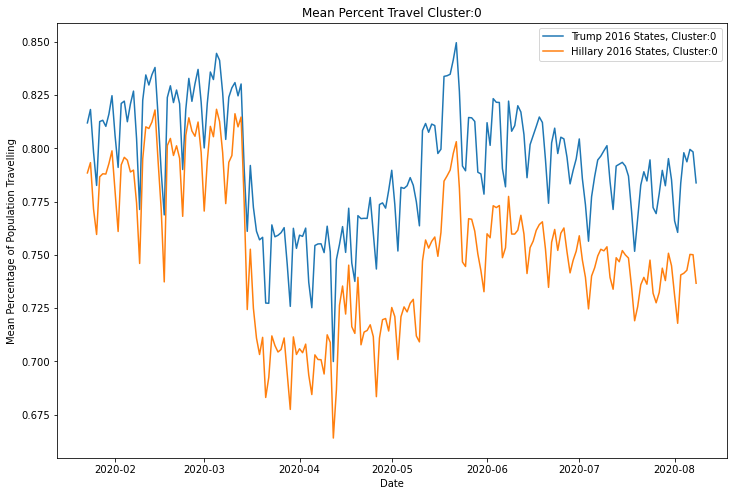

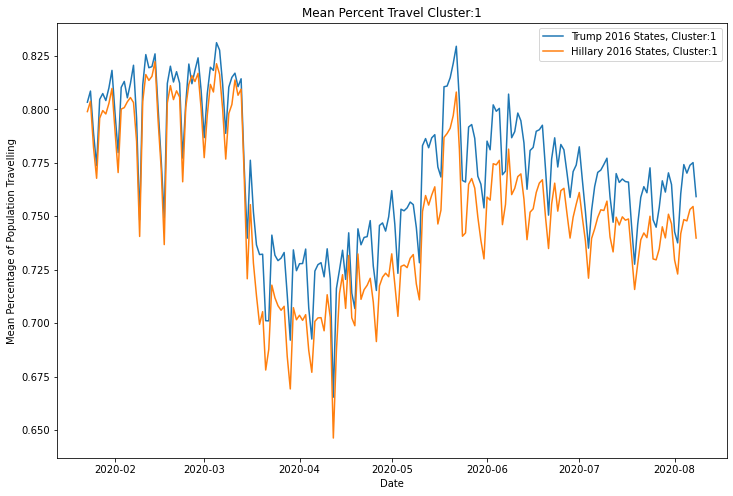

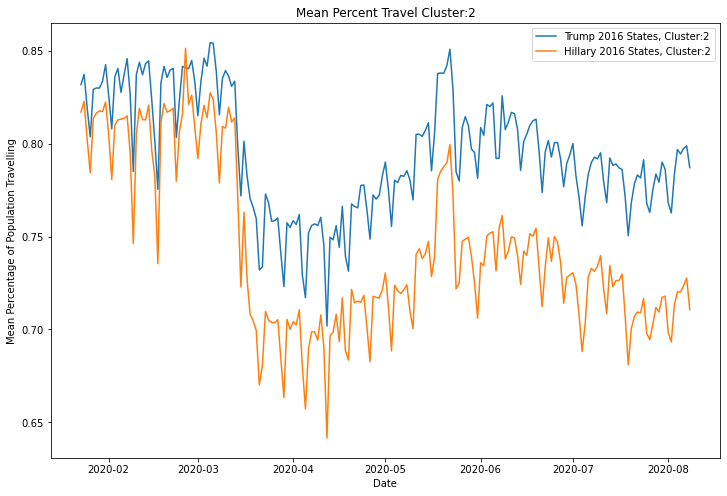

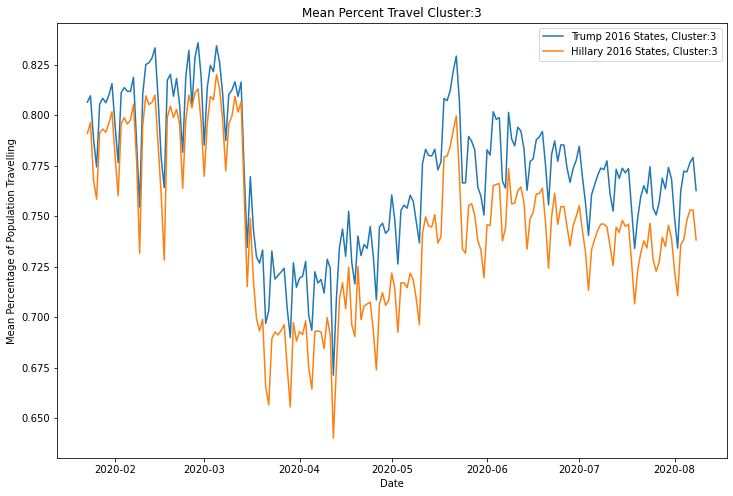

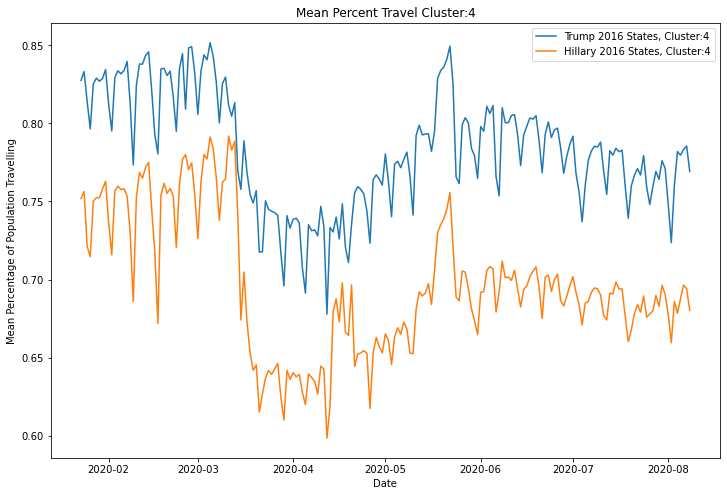

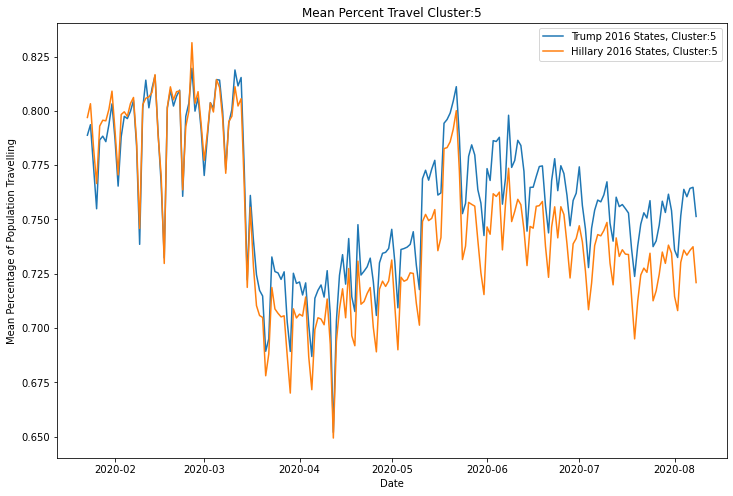

In [70]:
#Cluster wise comparisons for Mean Percent Travel
difference_df = pd.DataFrame()

for i, clusterNum in enumerate(states_clustered_df.Cluster.unique()):
    
    cluster_i_df = states_clustered_df[states_clustered_df['Cluster']==clusterNum]
    
    blue_cluster_i = cluster_i_df[cluster_i_df['Red']==0]
    red_cluster_i = cluster_i_df[cluster_i_df['Red']==1]
    print("Cluster:", clusterNum)
    print("Blue States:", blue_cluster_i.State.values)
    print("Red States:", red_cluster_i.State.values)
    print()
    
    blue_df = results_df[results_df.state_code.isin(blue_cluster_i.State.values)].groupby('date').mean().reset_index()
    red_df = results_df[results_df.state_code.isin(red_cluster_i.State.values)].groupby('date').mean().reset_index()

    #Plot the mean Percent Travel grouped by TRUMP vs HILLARY states and by date
    plt.figure(figsize=(12, 8))

    x1 = red_df.date
    y1 = red_df.Percent_Travel
    
    label_red = 'Trump 2016 States, Cluster:' + str(clusterNum)
    plt.plot(x1, y1, label = label_red)

    x2 = blue_df.date
    y2 =  blue_df.Percent_Travel
    
    label_blue = 'Hillary 2016 States, Cluster:' + str(clusterNum)
    plt.plot(x2, y2, label = label_blue)
    
    y3 = y1 - y2
    colName = 'Cluster_'+str(clusterNum)
    difference_df[colName] = y3


    plt.xlabel('Date')
    plt.ylabel('Mean Percentage of Population Travelling')
    title_string = 'Mean Percent Travel Cluster:' + str(clusterNum)
    plt.title(title_string)
    plt.legend()
    

In [72]:
#Add date and take mean over different clusters for each date
difference_df['Date'] = blue_df.date
difference_df['Mean_Clusters'] = (difference_df.Cluster_1 + difference_df.Cluster_2 + difference_df.Cluster_3 +
                                  difference_df.Cluster_4 + difference_df.Cluster_5 + difference_df.Cluster_0)/6

In [209]:
difference_df.set_index('Date', drop=True, inplace=True)

In [210]:
difference_df

Cluster_0  Cluster_1  Cluster_2  Cluster_3  Cluster_4  Cluster_5  \
Date                                                                           
2020-01-23   0.023483   0.004394   0.014825   0.015487   0.075598  -0.008166   
2020-01-24   0.024934   0.004798   0.014538   0.013324   0.076837  -0.009663   
2020-01-25   0.026735   0.006739   0.016858   0.020282   0.092816  -0.008806   
2020-01-26   0.023020   0.005932   0.019329   0.015959   0.081811  -0.011620   
2020-01-27   0.025934   0.008808   0.015583   0.014192   0.075093  -0.006395   
2020-01-28   0.025127   0.007960   0.013542   0.015229   0.076581  -0.007342   
2020-01-29   0.022390   0.006285   0.012272   0.014611   0.074466  -0.009588   
2020-01-30   0.023247   0.007240   0.016384   0.013942   0.070830  -0.007044   
2020-01-31   0.025871   0.008459   0.020137   0.013988   0.071519  -0.005862   
2020-02-01   0.026004   0.008284   0.020988   0.015160   0.075914  -0.004017   
2020-02-02   0.030063   0.009332   0.027233   0.016447   0.079318  -0.005152   
2020-02-03   0.028828   0.010158   0.026031   0.015473   0.072397  -0.010207   
2020-02-04   0.026382   0.012245   0.027680   0.014931   0.073864  -0.002094   
2020-02-05   0.018053   0.001853   0.014429   0.016211   0.074104  -0.001022   
2020-02-06   0.031919   0.006579   0.023210   0.014204   0.075772  -0.003573   
2020-02-07   0.037066   0.017431   0.030830   0.013358   0.086342  -0.001395   
2020-02-08   0.030181   0.010786   0.031350   0.009113   0.082506  -0.002157   
2020-02-09   0.025338   0.007791   0.038678   0.022915   0.087433  -0.007338   
2020-02-10   0.027521   0.007593   0.032158   0.015455   0.071993  -0.001752   
2020-02-11   0.024358   0.009329   0.024774   0.015549   0.069430   0.008355   
2020-02-12   0.020415   0.005919   0.024117   0.020589   0.073046  -0.005017   
2020-02-13   0.022222   0.004549   0.030217   0.021836   0.071553   0.001839   
2020-02-14   0.019950   0.003633   0.023823   0.023427   0.070697  -0.000450   
2020-02-15   0.021099   0.005807   0.026935   0.023222   0.076064   0.001286   
2020-02-16   0.017557   0.004109   0.019205   0.018043   0.075161  -0.003847   
2020-02-17   0.031445   0.012447   0.039992   0.035804   0.108505   0.002572   
2020-02-18   0.022549   0.009090   0.021338   0.018430   0.080992  -0.000263   
2020-02-19   0.024701   0.009108   0.020018   0.015662   0.073631  -0.001508   
2020-02-20   0.024832   0.008221   0.018729   0.010539   0.075496  -0.002912   
2020-02-21   0.026172   0.008945   0.021899   0.015343   0.075067  -0.002129   
2020-02-22   0.025598   0.006471   0.021478   0.009356   0.063557   0.000391   
2020-02-23   0.021977   0.011067   0.023553   0.017890   0.074323  -0.002984   
2020-02-24   0.012068   0.002000   0.017163   0.021672   0.074126   0.004749   
2020-02-25   0.018498   0.009460   0.025714   0.022177   0.067803   0.003728   
2020-02-26   0.013901  -0.003767  -0.010466   0.000549   0.029104  -0.011836   
2020-02-27   0.024667   0.005251   0.019242   0.017658   0.077876  -0.003628   
2020-02-28   0.024690   0.007241   0.018701   0.022895   0.074356  -0.002668   
2020-02-29   0.023686   0.008597   0.024546   0.022566   0.077659  -0.002642   
2020-03-01   0.029643   0.009353   0.023116   0.015358   0.079575  -0.006981   
2020-03-02   0.027139   0.010074   0.022844   0.017703   0.071290  -0.001899   
2020-03-03   0.025510   0.007997   0.025448   0.015399   0.063794   0.000080   
2020-03-04   0.026835   0.010087   0.027802   0.013999   0.063535   0.001712   
2020-03-05   0.026240   0.009841   0.026977   0.014340   0.060363   0.000060   
2020-03-06   0.028728   0.011300   0.030196   0.013096   0.059130   0.003417   
2020-03-07   0.028104   0.011709   0.032773   0.012774   0.061287   0.003388   
2020-03-08   0.030125   0.012023   0.036575   0.015017   0.062360   0.001773   
2020-03-09   0.030551   0.012330   0.025855   0.014509   0.063037  -0.000590   
2020-03-10   0.031780   0.012700   0.031009   0.012891   0.065254   0.003023   
2020-03-11  

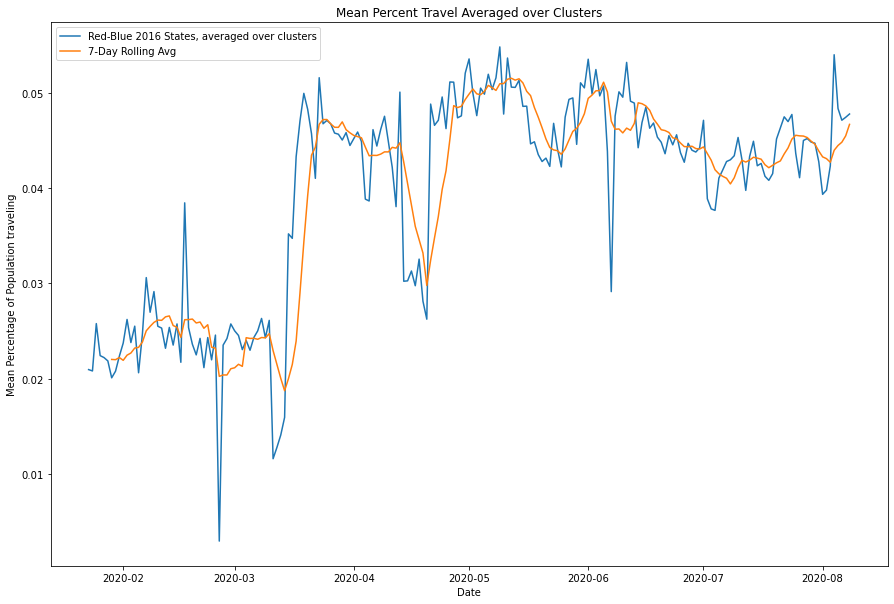

In [212]:
plt.figure(figsize=(15, 10))

x1 = red_df.date
y1 = difference_df['Mean_Clusters']

label_red = 'Red-Blue 2016 States, averaged over clusters'
plt.plot(x1, y1, label = label_red)

#difference_df.set_index('Date')
y2 = difference_df['Mean_Clusters'].rolling(window=7).mean()
plt.plot(x1, y2, label = '7-Day Rolling Avg')


plt.xlabel('Date')
plt.ylabel('Mean Percentage of Population traveling')
plt.title('Mean Percent Travel Averaged over Clusters')
plt.legend()

In [75]:
difference_df[0:50].Mean_Clusters.mean()

0.02341985751608389

In [76]:
difference_df[51:].Mean_Clusters.mean()

0.0449184137630988

Cluster: 0
Blue States: ['NH' 'RI' 'HI' 'DC' 'DE' 'CT' 'MD' 'VT' 'ME']
Red States: ['IA' 'AR' 'MS' 'AL' 'OK' 'SC' 'LA' 'KY' 'WV']

Cluster: 1
Blue States: ['MN' 'WA' 'VA' 'MA' 'CO']
Red States: ['MO' 'WI' 'AZ' 'IN' 'TN']

Cluster: 2
Blue States: ['CA']
Red States: ['TX']

Cluster: 3
Blue States: ['NJ' 'IL']
Red States: ['MI' 'NC' 'PA' 'OH' 'GA']

Cluster: 4
Blue States: ['NY']
Red States: ['FL']

Cluster: 5
Blue States: ['NM' 'NV' 'OR']
Red States: ['SD' 'AK' 'ND' 'NE' 'KS' 'MT' 'WY' 'UT' 'ID']



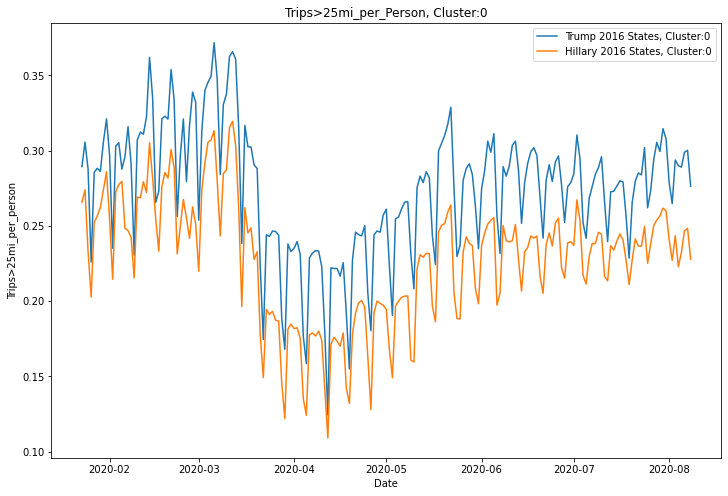

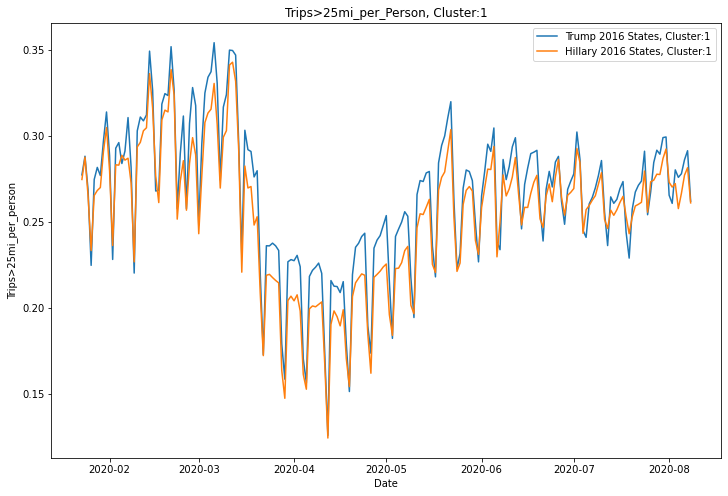

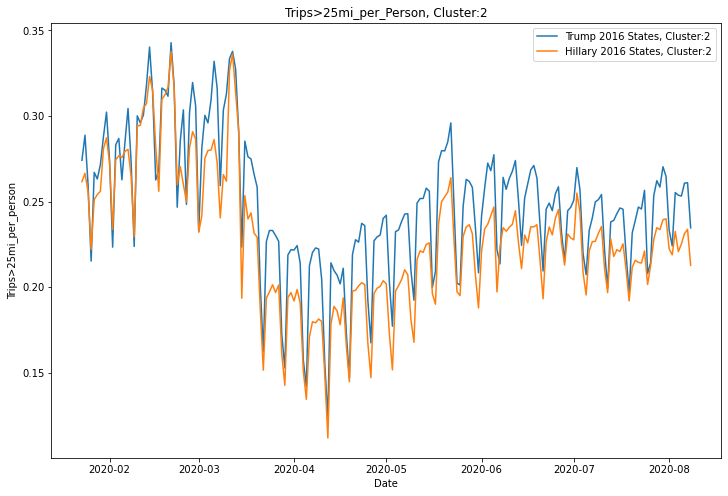

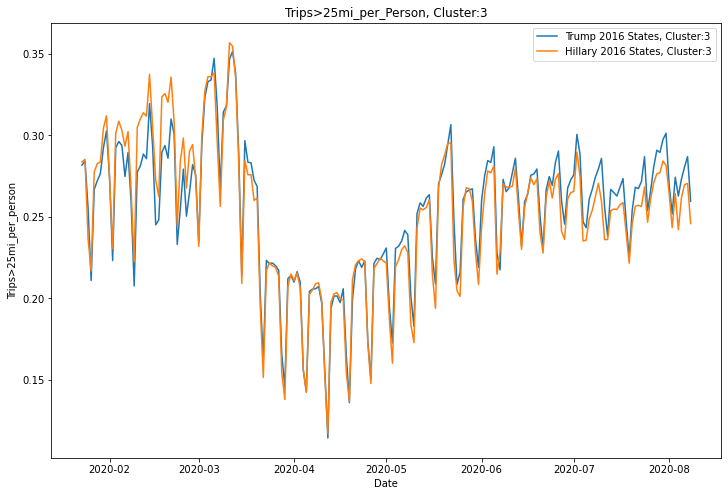

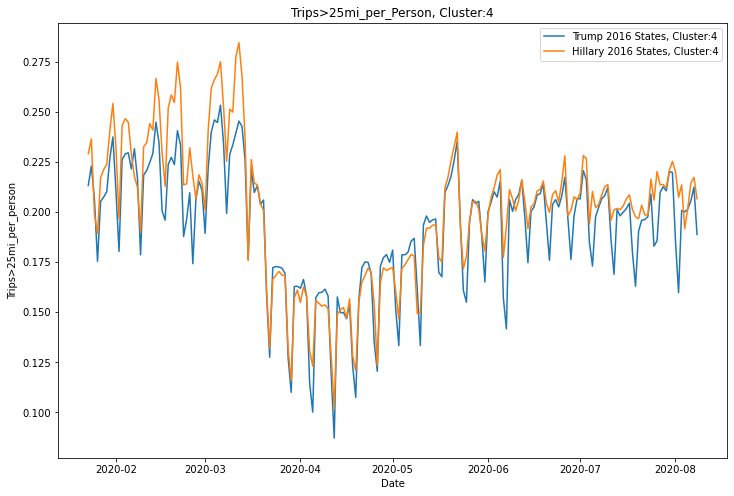

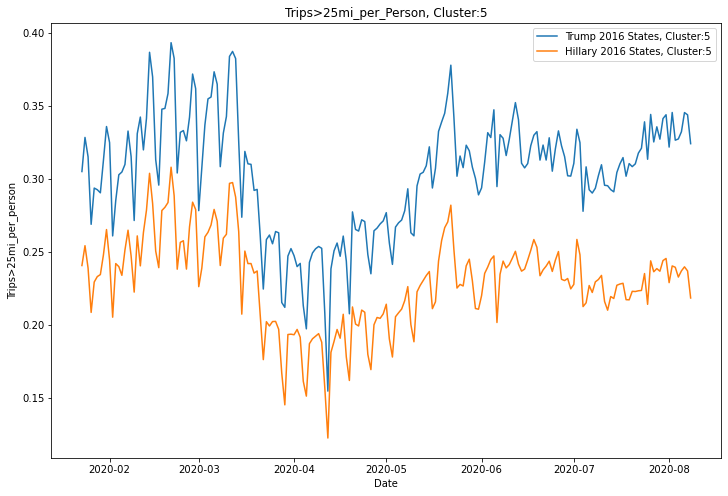

In [77]:
#Cluster wise comparisons
for i, clusterNum in enumerate(states_clustered_df.Cluster.unique()):
    
    cluster_i_df = states_clustered_df[states_clustered_df['Cluster']==clusterNum]
    
    blue_cluster_i = cluster_i_df[cluster_i_df['Red']==0]
    red_cluster_i = cluster_i_df[cluster_i_df['Red']==1]
    print("Cluster:", clusterNum)
    print("Blue States:", blue_cluster_i.State.values)
    print("Red States:", red_cluster_i.State.values)
    print()
    
    blue_df = results_df[results_df.state_code.isin(blue_cluster_i.State.values)].groupby('date').mean().reset_index()
    red_df = results_df[results_df.state_code.isin(red_cluster_i.State.values)].groupby('date').mean().reset_index()

    #Plot the mean Percent Travel grouped by TRUMP vs HILLARY states and by date
    plt.figure(figsize=(12, 8))

    x1 = red_df.date
    y1 = red_df['Trips>25mi_per_person']
    
    label_red = 'Trump 2016 States, Cluster:' + str(clusterNum)
    plt.plot(x1, y1, label = label_red)

    x2 = blue_df.date
    y2 =  blue_df['Trips>25mi_per_person']
    
    label_blue = 'Hillary 2016 States, Cluster:' + str(clusterNum)
    plt.plot(x2, y2, label = label_blue)

    plt.xlabel('Date')
    plt.ylabel('Trips>25mi_per_person')
    title_string = 'Trips>25mi_per_Person, Cluster:' + str(clusterNum)
    plt.title(title_string)
    plt.legend()

Cluster: 0
Blue States: ['NH' 'RI' 'HI' 'DC' 'DE' 'CT' 'MD' 'VT' 'ME']
Red States: ['IA' 'AR' 'MS' 'AL' 'OK' 'SC' 'LA' 'KY' 'WV']

Cluster: 1
Blue States: ['MN' 'WA' 'VA' 'MA' 'CO']
Red States: ['MO' 'WI' 'AZ' 'IN' 'TN']

Cluster: 2
Blue States: ['CA']
Red States: ['TX']

Cluster: 3
Blue States: ['NJ' 'IL']
Red States: ['MI' 'NC' 'PA' 'OH' 'GA']

Cluster: 4
Blue States: ['NY']
Red States: ['FL']

Cluster: 5
Blue States: ['NM' 'NV' 'OR']
Red States: ['SD' 'AK' 'ND' 'NE' 'KS' 'MT' 'WY' 'UT' 'ID']



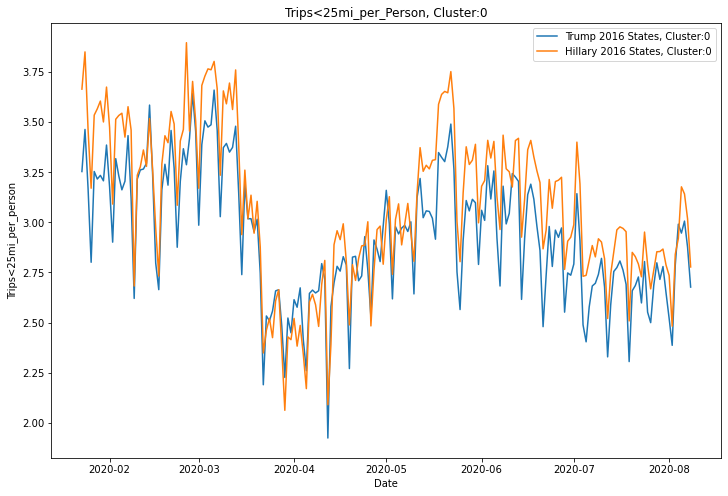

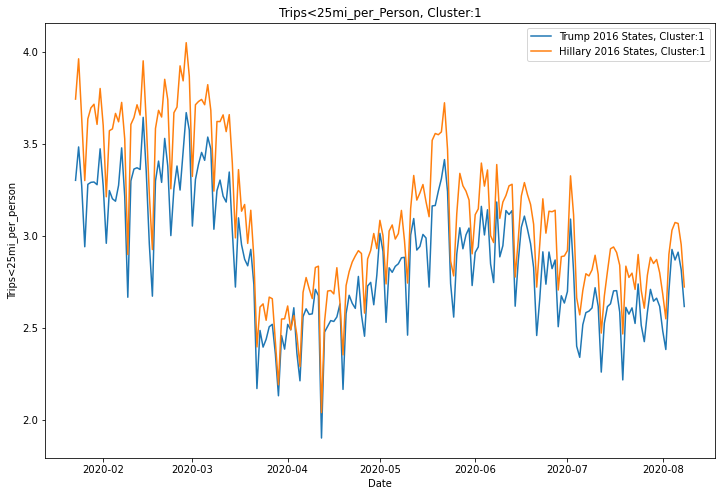

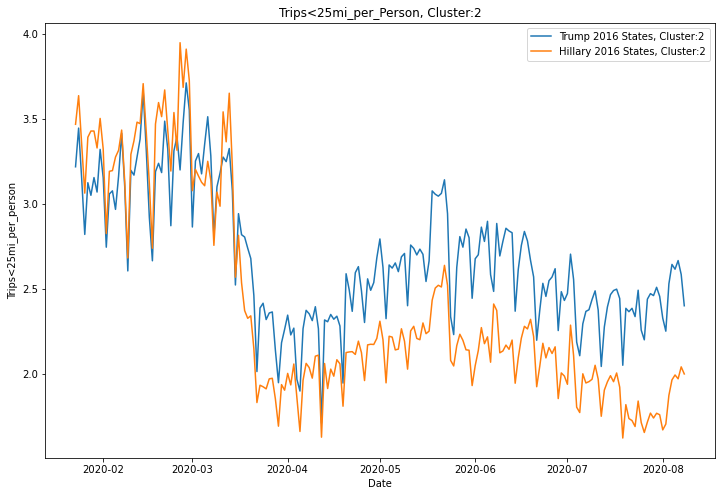

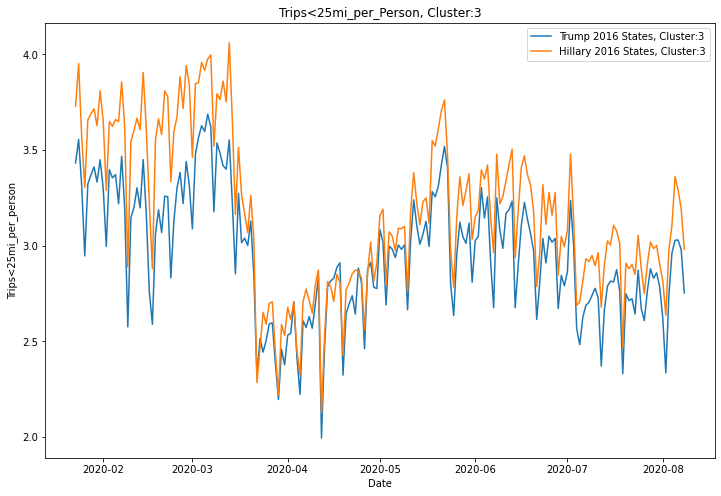

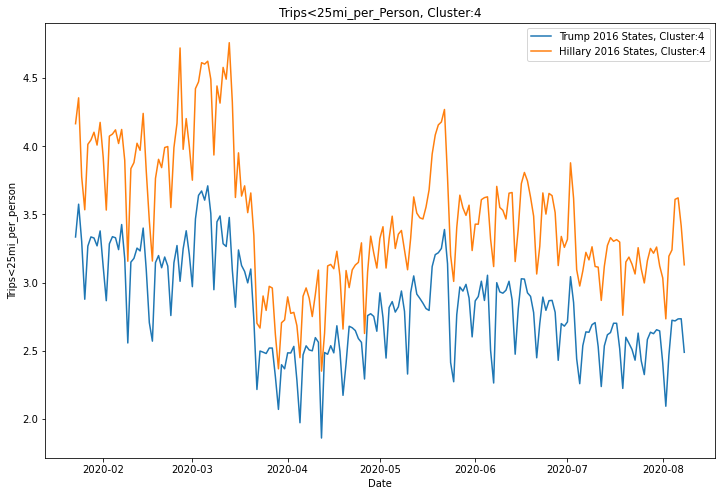

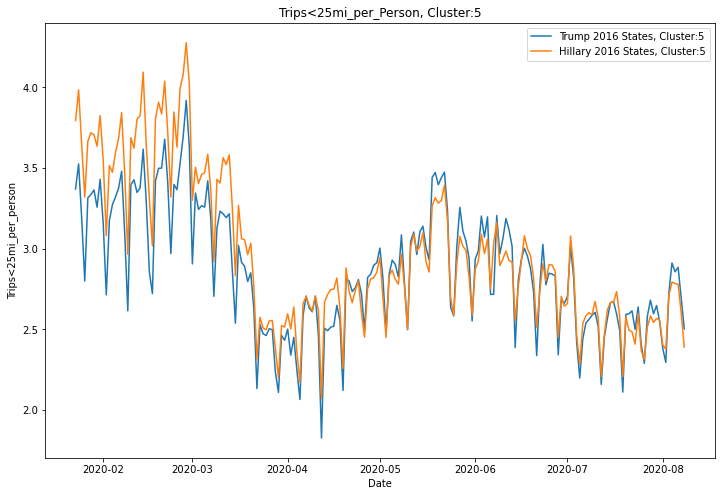

In [78]:
#Cluster wise comparisons
for i, clusterNum in enumerate(states_clustered_df.Cluster.unique()):
    
    cluster_i_df = states_clustered_df[states_clustered_df['Cluster']==clusterNum]
    
    blue_cluster_i = cluster_i_df[cluster_i_df['Red']==0]
    red_cluster_i = cluster_i_df[cluster_i_df['Red']==1]
    print("Cluster:", clusterNum)
    print("Blue States:", blue_cluster_i.State.values)
    print("Red States:", red_cluster_i.State.values)
    print()
    
    blue_df = results_df[results_df.state_code.isin(blue_cluster_i.State.values)].groupby('date').mean().reset_index()
    red_df = results_df[results_df.state_code.isin(red_cluster_i.State.values)].groupby('date').mean().reset_index()

    #Plot the mean Percent Travel grouped by TRUMP vs HILLARY states and by date
    plt.figure(figsize=(12, 8))

    x1 = red_df.date
    y1 = red_df['Trips<25mi_per_person']
    
    label_red = 'Trump 2016 States, Cluster:' + str(clusterNum)
    plt.plot(x1, y1, label = label_red)

    x2 = blue_df.date
    y2 =  blue_df['Trips<25mi_per_person']
    
    label_blue = 'Hillary 2016 States, Cluster:' + str(clusterNum)
    plt.plot(x2, y2, label = label_blue)


    plt.xlabel('Date')
    plt.ylabel('Trips<25mi_per_person')
    title_string = 'Trips<25mi_per_Person, Cluster:' + str(clusterNum)
    plt.title(title_string)
    plt.legend()

## Analyze the Growth Rate by State Clusters

In [79]:
#Get the 7 Day rolling average for each state 
State_Cases_7Day_Avg = State_Cases_transposed.rolling(window=7).mean().round()

In [80]:
#Drop the NaNs and convert to int
State_Cases_7Day_Avg = State_Cases_7Day_Avg[6:].astype(int)
State_Cases_7Day_Avg

States          CA      FL      TX      NY      GA      IL      AZ      NJ  \
Date                                                                         
2020-01-28       1       0       0       0       0       1       0       0   
2020-01-29       1       0       0       0       0       1       1       0   
2020-01-30       1       0       0       0       0       1       1       0   
2020-01-31       2       0       0       0       0       1       1       0   
2020-02-01       2       0       0       0       0       1       1       0   
2020-02-02       2       0       0       0       0       1       1       0   
2020-02-03       3       0       0       0       0       2       1       0   
2020-02-04       4       0       0       0       0       2       1       0   
2020-02-05       4       0       0       0       0       2       1       0   
2020-02-06       5       0       0       0       0       2       1       0   
2020-02-07       5       0       0       0       0       2       1       0   
2020-02-08       6       0       0       0       0       2       1       0   
2020-02-09       6       0       0       0       0       2       1       0   
2020-02-10       6       0       0       0       0       2       1       0   
2020-02-11       6       0       0       0       0       2       1       0   
2020-02-12       6       0       0       0       0       2       1       0   
2020-02-13       7       0       0       0       0       2       1       0   
2020-02-14       7       0       0       0       0       2       1       0   
2020-02-15       7       0       0       0       0       2       1       0   
2020-02-16       7       0       0       0       0       2       1       0   
2020-02-17       8       0       0       0       0       2       1       0   
2020-02-18       8       0       0       0       0       2       1       0   
2020-02-19       8       0       0       0       0       2       1       0   
2020-02-20       8       0       0       0       0       2       1       0   
2020-02-21       8       0       0       0       0       2       1       0   
2020-02-22       9       0       0       0       0       2       1       0   
2020-02-23       9       0       0       0       0       2       1       0   
2020-02-24       9       0       0       0       0       2       1       0   
2020-02-25       9       0       0       0       0       2       1       0   
2020-02-26      10       0       0       0       0       2       1       0   
2020-02-27      10       0       0       0       0       2       1       0   
2020-02-28      10       0       0       0       0       2       1       0   
2020-02-29      11       0       0       0       0       2       1       0   
2020-03-01      11       0       0       0       0       2       1       0   
2020-03-02      12       0       0       0       0       2       1       0   
2020-03-03      15       0       0       0       0       3       1       0   
2020-03-04      18       1       0       2       1       3       1       0   
2020-03-05      24       1       0       5       1       3       1       0   
2020-03-06      31       2       1      10       1       4       1       1   
2020-03-07      41       3       2      21       2       4       2       1   
2020-03-08      52       4       4      36       3       5       2       2   
2020-03-09      64       6       6      56       4       5       2       3   
2020-03-10      81       8       8      77       6       7       3       5   
2020-03-11     101      11      11     107       9      10       4       8   
2020-03-12     126      15      14     150      13      13       5      12   
2020-03-13     157      21      20     206      19      19       6      19   
2020-03-14     199      31      27     283      29      28       8      28   
2020-03-15     239      44      35     355      42      36       9      37   
2020-03-16     304      57      45     473      58      47      11      62   
2020-03-17     383    

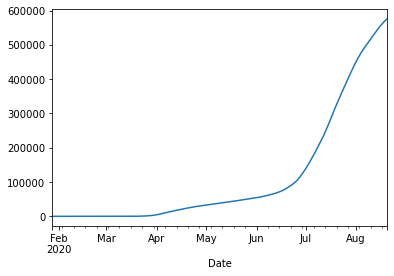

In [132]:
State_Cases_7Day_Avg.FL.plot()

In [126]:
State_Cases_7Day_Avg.shape

(206, 51)

In [176]:
def get_rolling_avg(data_list, window_size):
    '''
    Calculate a rolling average of a data list as per window size
    Inputs: data_list of numbers, window_size specifying width of rolling avg
    Returns: List with rolling average values computed
    '''
    rolling_avg_list = [1]*(window_size)
    
    for i in range(0, len(data_list)-window_size):
        #Get the data range as per window size
        window_i_val = np.mean(data_list[i:i+window_size])
        
        rolling_avg_list.append(window_i_val)
        
    return rolling_avg_list
        

In [655]:
#Function to calculate the growth rate and plot by State
#X_t = (1+r)^t * X_0
def stateInfectionRate(stateCode_list):
    #Create Plot
    plt.figure(figsize=(15, 10))
    growth_rate_avg_dict = {}
    diff_list_dict = {}
    
    for stateCode in stateCode_list:
        print("Calculating and Plotting Growth rate for State:", stateCode)
        diff_list = [0]
        growth_rate_list = [1, 1]

        for i, val in enumerate(State_Cases_7Day_Avg[stateCode].values[1:]):
            diff_i = val - State_Cases_7Day_Avg[stateCode].values[i]
            diff_list.append(diff_i)

            if(i>0):#Calculate growth rate from 2nd value
                #print(diff_list[i], diff_list[i-1])
                try:
                    growth_rate = diff_list[i]/diff_list[i-1]
                except:
                    growth_rate = 1
                if(np.isnan(growth_rate) or np.isinf(growth_rate) ):
                    growth_rate = 1
                growth_rate_list.append(growth_rate) 
        
        #Store the diff list
        diff_list_dict[stateCode] = diff_list
        
        #Add the daily difference column to df
        diff_col_name = 'Diff_'+stateCode
        State_Cases_7Day_Avg[diff_col_name] = diff_list
        
        
        #Get rolling average of
        win_size = 10
        growth_rate_avg = get_rolling_avg(growth_rate_list, win_size)
        growth_rate_avg_dict[stateCode] = growth_rate_avg
        
        #Add Growth Rate column to df
        growthRate_col_name = 'Growth_'+stateCode
        State_Cases_7Day_Avg[growthRate_col_name] = growth_rate_avg
        
        skip_rows = 10
        
        if(stateCode in TRUMP_2016_STATES):
            plt_color_str = 'r'
        if(stateCode in HILLARY_2016_STATES):
            plt_color_str = 'b' 

        plt.plot(State_Cases_7Day_Avg.index[skip_rows:], growth_rate_avg[skip_rows:], 
                 plt_color_str, label=stateCode)
        
    
    plt.xlabel('Date')
    plt.ylabel('Growth Rate')
    
    plt.ylim(0.7, 1.4)
    plt.yticks(np.arange(0.9, 1.4, step=0.025)) 
    
    plt.title('Infection Rate by State')
    plt.grid()
    plt.legend()
    plt.show()
    
    return diff_list_dict, growth_rate_avg_dict

In [656]:
#Function to get correlations between two time series - infection rate and travel difference
def get_Correlations(start_date, end_date, series_infectionDiff, series_travelDiff, clusterName):
    #Subset the date ranges
    infectionRate_series = series_infectionDiff[(series_infectionDiff.index > start_date) &\
                                                (series_infectionDiff.index < end_date)]
    travelDiff_Series = series_travelDiff[clusterName][(series_travelDiff.index > start_date) &\
                                                        (series_travelDiff.index < end_date)]
    
    #Get Correlations
    print("Pearson Correlation:", stats.pearsonr(infectionRate_series, travelDiff_Series))
    
    #Plot
    plt.figure(figsize=(10, 8))
    infectionRate_series.plot(label = 'Infection Rate Difference (Red-Blue)')
    travelDiff_Series.plot(label='Percent Travel Difference (Red-Blue)')
    plt.xlabel('Date')
    plt.ylabel('Difference')
    
    plt.title('Plot of Growth Rate Difference and Percent Travel Difference')
    plt.grid()
    plt.legend()
    
    return None

## Cluster 4 - NY and FL

Calculating and Plotting Growth rate for State: NY
Calculating and Plotting Growth rate for State: FL


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars


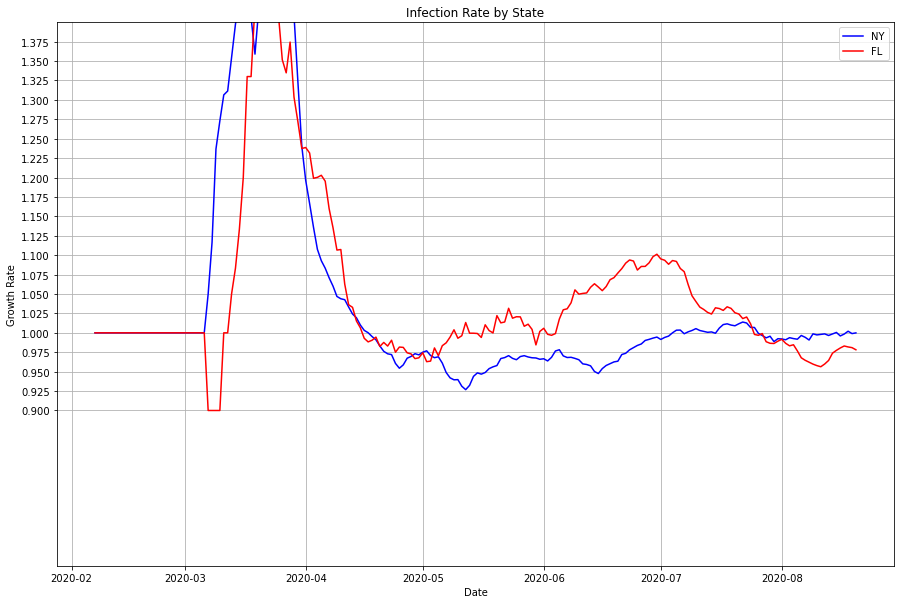

In [657]:
state_codes = ['NY', 'FL']
diffList_dict, growthRate_dict = stateInfectionRate(state_codes)

In [444]:
State_Cases_7Day_Avg

States          CA      FL      TX      NY      GA      IL      AZ      NJ  \
Date                                                                         
2020-01-28       1       0       0       0       0       1       0       0   
2020-01-29       1       0       0       0       0       1       1       0   
2020-01-30       1       0       0       0       0       1       1       0   
2020-01-31       2       0       0       0       0       1       1       0   
2020-02-01       2       0       0       0       0       1       1       0   
2020-02-02       2       0       0       0       0       1       1       0   
2020-02-03       3       0       0       0       0       2       1       0   
2020-02-04       4       0       0       0       0       2       1       0   
2020-02-05       4       0       0       0       0       2       1       0   
2020-02-06       5       0       0       0       0       2       1       0   
2020-02-07       5       0       0       0       0       2       1       0   
2020-02-08       6       0       0       0       0       2       1       0   
2020-02-09       6       0       0       0       0       2       1       0   
2020-02-10       6       0       0       0       0       2       1       0   
2020-02-11       6       0       0       0       0       2       1       0   
2020-02-12       6       0       0       0       0       2       1       0   
2020-02-13       7       0       0       0       0       2       1       0   
2020-02-14       7       0       0       0       0       2       1       0   
2020-02-15       7       0       0       0       0       2       1       0   
2020-02-16       7       0       0       0       0       2       1       0   
2020-02-17       8       0       0       0       0       2       1       0   
2020-02-18       8       0       0       0       0       2       1       0   
2020-02-19       8       0       0       0       0       2       1       0   
2020-02-20       8       0       0       0       0       2       1       0   
2020-02-21       8       0       0       0       0       2       1       0   
2020-02-22       9       0       0       0       0       2       1       0   
2020-02-23       9       0       0       0       0       2       1       0   
2020-02-24       9       0       0       0       0       2       1       0   
2020-02-25       9       0       0       0       0       2       1       0   
2020-02-26      10       0       0       0       0       2       1       0   
2020-02-27      10       0       0       0       0       2       1       0   
2020-02-28      10       0       0       0       0       2       1       0   
2020-02-29      11       0       0       0       0       2       1       0   
2020-03-01      11       0       0       0       0       2       1       0   
2020-03-02      12       0       0       0       0       2       1       0   
2020-03-03      15       0       0       0       0       3       1       0   
2020-03-04      18       1       0       2       1       3       1       0   
2020-03-05      24       1       0       5       1       3       1       0   
2020-03-06      31       2       1      10       1       4       1       1   
2020-03-07      41       3       2      21       2       4       2       1   
2020-03-08      52       4       4      36       3       5       2       2   
2020-03-09      64       6       6      56       4       5       2       3   
2020-03-10      81       8       8      77       6       7       3       5   
2020-03-11     101      11      11     107       9      10       4       8   
2020-03-12     126      15      14     150      13      13       5      12   
2020-03-13     157      21      20     206      19      19       6      19   
2020-03-14     199      31      27     283      29      28       8      28   
2020-03-15     239      44      35     355      42      36       9      37   
2020-03-16     304      57      45     473      58      47      11      62   
2020-03-17     383    

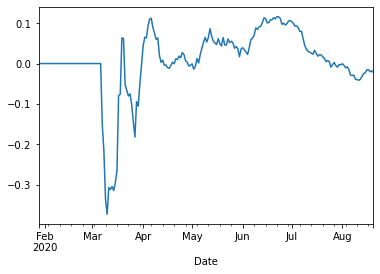

In [391]:
(State_Cases_7Day_Avg.Growth_FL - State_Cases_7Day_Avg.Growth_NY).plot()

In [432]:
diff_fl_ny = (State_Cases_7Day_Avg.Growth_FL - State_Cases_7Day_Avg.Growth_NY)

In [642]:
#Specify date range for correlations
startDate = '2020-02-25'
endDate = '2020-07-10'

Pearson Correlation: (0.46768931413537007, 1.0704611880101806e-08)


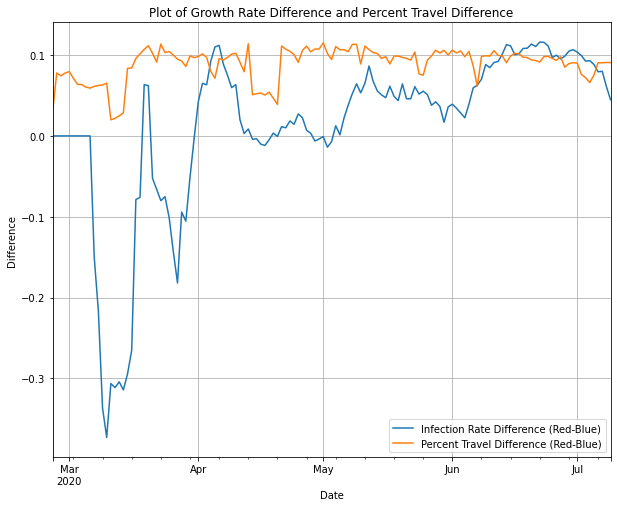

In [643]:
get_Correlations(startDate, endDate, diff_fl_ny, difference_df, 'Cluster_4')

## Cluster 2 - CA and TX

Calculating and Plotting Growth rate for State: CA
Calculating and Plotting Growth rate for State: TX


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars


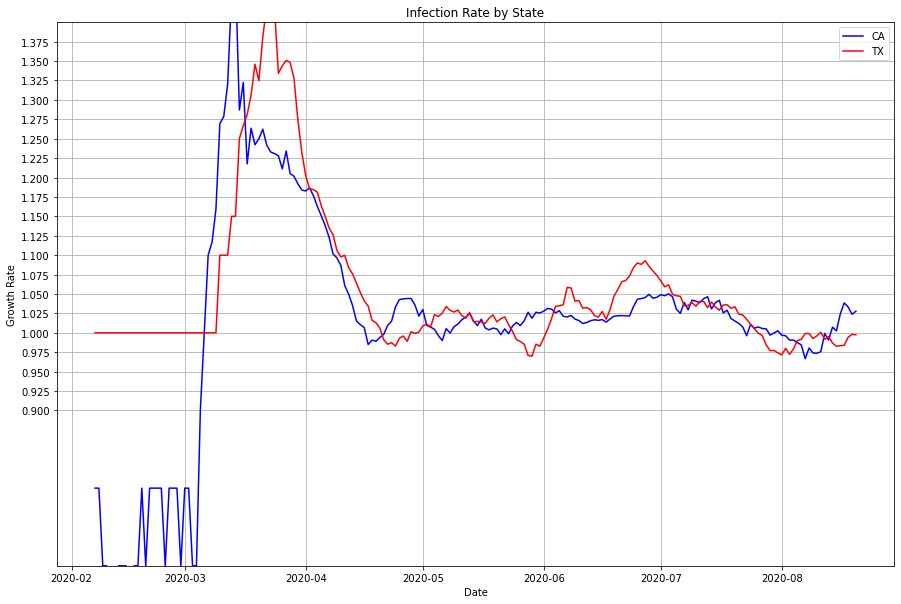

In [437]:
state_codes = ['CA', 'TX']
diffList_dict, growthRate_dict = stateInfectionRate(state_codes)

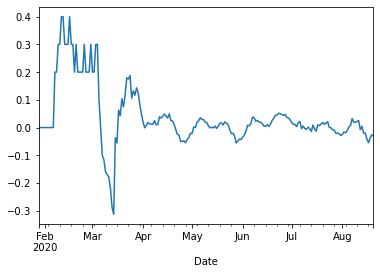

In [438]:
(State_Cases_7Day_Avg.Growth_TX - State_Cases_7Day_Avg.Growth_CA).plot()

In [570]:
#Specify date range for correlations
startDate = '2020-03-01'
endDate = '2020-06-15'

Pearson Correlation: (0.19362150733369107, 0.047810317517749674)


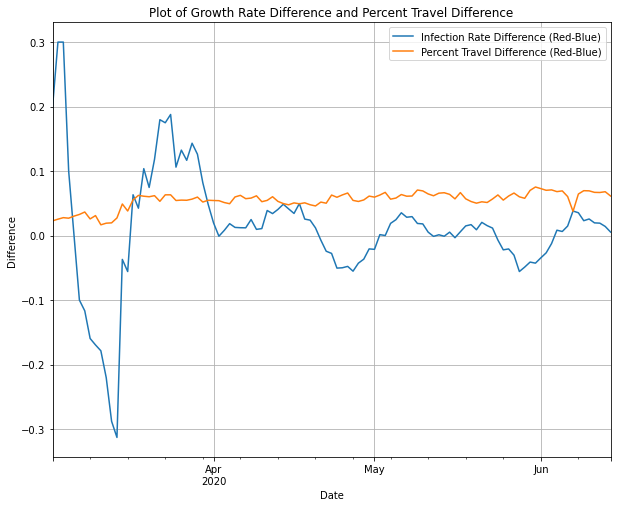

In [571]:
diff_tx_ca = State_Cases_7Day_Avg.Growth_TX - State_Cases_7Day_Avg.Growth_CA
get_Correlations(startDate, endDate, diff_tx_ca, difference_df, 'Cluster_2')

## Cluster 0
- Blue States: ['NH', 'RI', 'HI', 'DC', 'DE', 'CT', 'MD', 'VT', 'ME']
- Red States: ['IA', 'AR', 'MS', 'AL', 'OK', 'SC', 'LA', 'KY', 'WV']

Calculating and Plotting Growth rate for State: NH
Calculating and Plotting Growth rate for State: RI
Calculating and Plotting Growth rate for State: HI
Calculating and Plotting Growth rate for State: DC
Calculating and Plotting Growth rate for State: DE
Calculating and Plotting Growth rate for State: CT
Calculating and Plotting Growth rate for State: MD
Calculating and Plotting Growth rate for State: VT
Calculating and Plotting Growth rate for State: ME
Calculating and Plotting Growth rate for State:

C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encounte

 IA
Calculating and Plotting Growth rate for State: AR
Calculating and Plotting Growth rate for State: MS
Calculating and Plotting Growth rate for State: AL
Calculating and Plotting Growth rate for State: OK
Calculating and Plotting Growth rate for State: SC
Calculating and Plotting Growth rate for State: LA
Calculating and Plotting Growth rate for State: KY
Calculating and Plotting Growth rate for State: WV


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encounte

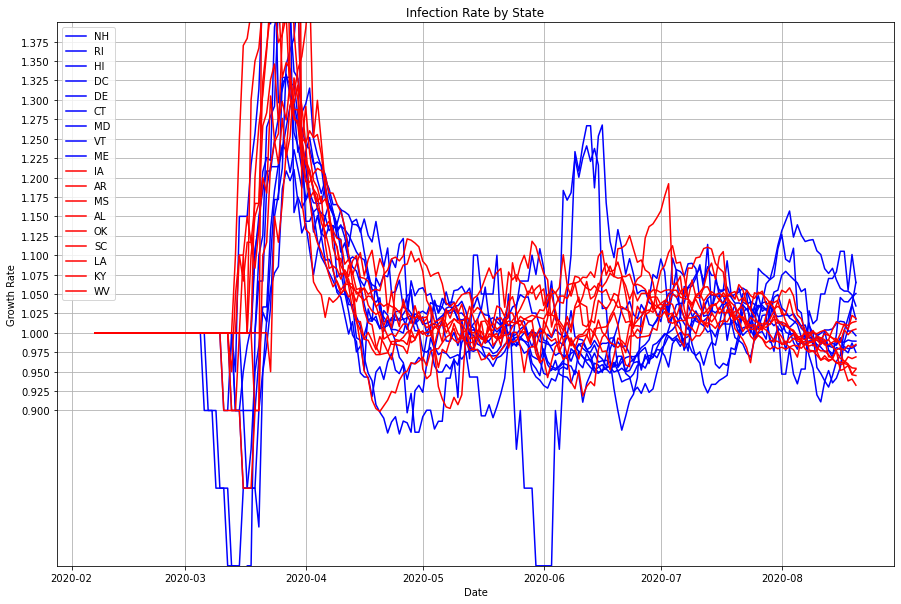

In [588]:
state_codes = ['NH', 'RI', 'HI', 'DC', 'DE', 'CT', 'MD', 'VT', 'ME', 'IA', 'AR', 'MS', 'AL', 'OK', 'SC', 'LA', 'KY', 'WV']
diffList_dict, growthRate_dict = stateInfectionRate(state_codes)

In [589]:
#Get the mean of all blue and all red states in Cluster
#'NH', 'RI', 'HI', 'DC', 'DE', 'CT', 'MD', 'VT', 'ME',
mean_blue =  (State_Cases_7Day_Avg.Growth_NH + State_Cases_7Day_Avg.Growth_RI + State_Cases_7Day_Avg.Growth_HI + 
             State_Cases_7Day_Avg.Growth_DC + State_Cases_7Day_Avg.Growth_DE + State_Cases_7Day_Avg.Growth_CT + 
             State_Cases_7Day_Avg.Growth_MD + State_Cases_7Day_Avg.Growth_VT + State_Cases_7Day_Avg.Growth_ME)/9

#['IA', 'AR', 'MS', 'AL', 'OK', 'SC', 'LA', 'KY', 'WV']
mean_red = (State_Cases_7Day_Avg.Growth_IA + State_Cases_7Day_Avg.Growth_AR + State_Cases_7Day_Avg.Growth_MS + 
           State_Cases_7Day_Avg.Growth_AL + State_Cases_7Day_Avg.Growth_OK + State_Cases_7Day_Avg.Growth_SC + 
           State_Cases_7Day_Avg.Growth_LA + State_Cases_7Day_Avg.Growth_KY + State_Cases_7Day_Avg.Growth_WV)/9

red_blue_diff_0 = mean_red - mean_blue

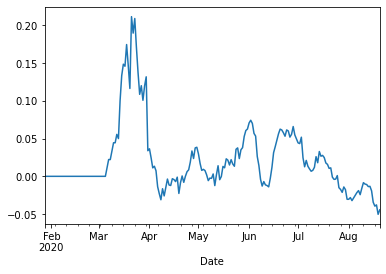

In [590]:
red_blue_diff_0.plot()

In [591]:
#Specify date range for correlations
startDate = '2020-02-01'
endDate = '2020-06-15'

Pearson Correlation: (0.17206138438259497, 0.04681763827178976)


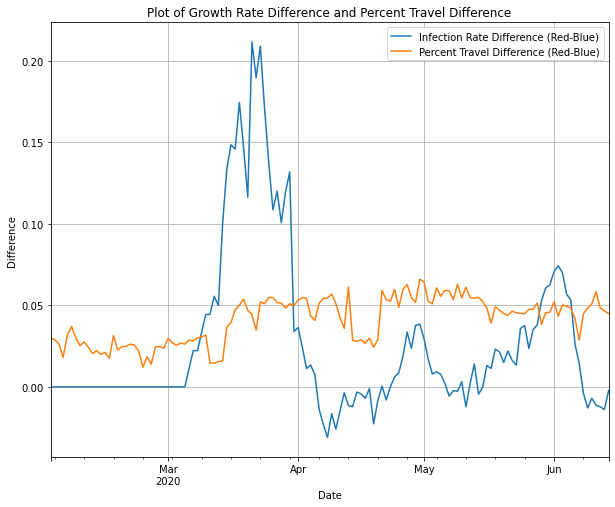

In [592]:
get_Correlations(startDate, endDate, red_blue_diff_0, difference_df, 'Cluster_0')

## Cluster 1
- Blue States:  ['WA', 'MA', 'CO', 'VA', 'MN']
- Red States: ['IN', 'AZ', 'TN', 'WI', 'MO']

Calculating and Plotting Growth rate for State: WA


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars


Calculating and Plotting Growth rate for State: MA
Calculating and Plotting Growth rate for State: CO
Calculating and Plotting Growth rate for State: VA
Calculating and Plotting Growth rate for State: MN
Calculating and Plotting Growth rate for State: IN
Calculating and Plotting Growth rate for State: AZ
Calculating and Plotting Growth rate for State: TN
Calculating and Plotting Growth rate for State: WI
Calculating and Plotting Growth rate for State: MO


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encounte

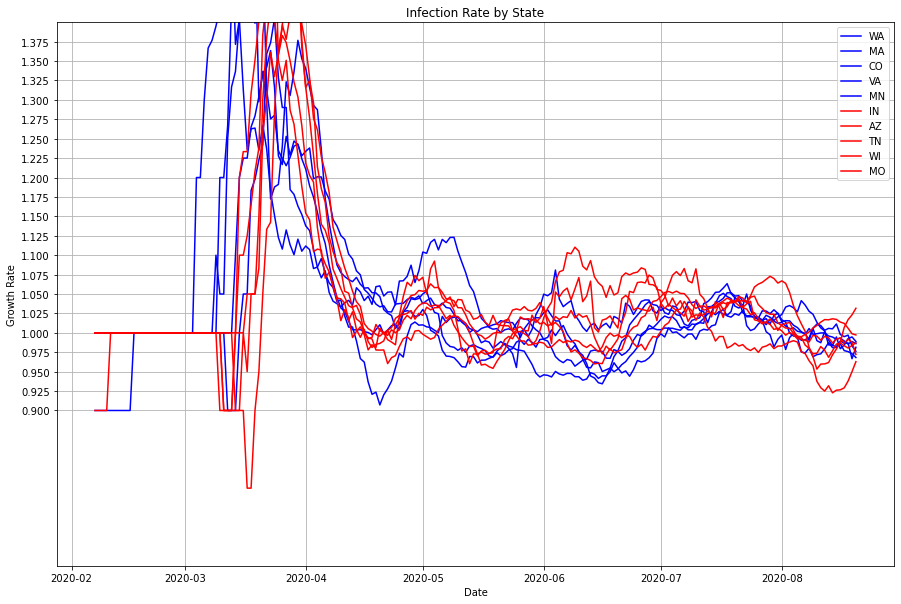

In [593]:
state_codes = ['WA', 'MA', 'CO', 'VA', 'MN', 'IN', 'AZ', 'TN', 'WI', 'MO']
diffList_dict, growthRate_dict = stateInfectionRate(state_codes)

In [594]:
#Get the mean of all blue and all red states in Cluster
mean_blue =  (State_Cases_7Day_Avg.Growth_MA + State_Cases_7Day_Avg.Growth_WA + State_Cases_7Day_Avg.Growth_CO + 
             State_Cases_7Day_Avg.Growth_VA + State_Cases_7Day_Avg.Growth_MN)/5
mean_red = (State_Cases_7Day_Avg.Growth_AZ + State_Cases_7Day_Avg.Growth_TN + State_Cases_7Day_Avg.Growth_IN + 
           State_Cases_7Day_Avg.Growth_WI + State_Cases_7Day_Avg.Growth_MO)/5

red_blue_diff = mean_red - mean_blue

In [605]:
#Specify date range for correlations
startDate = '2020-03-01'
endDate = '2020-07-01'

Pearson Correlation: (0.3901121016424076, 9.722653261116562e-06)


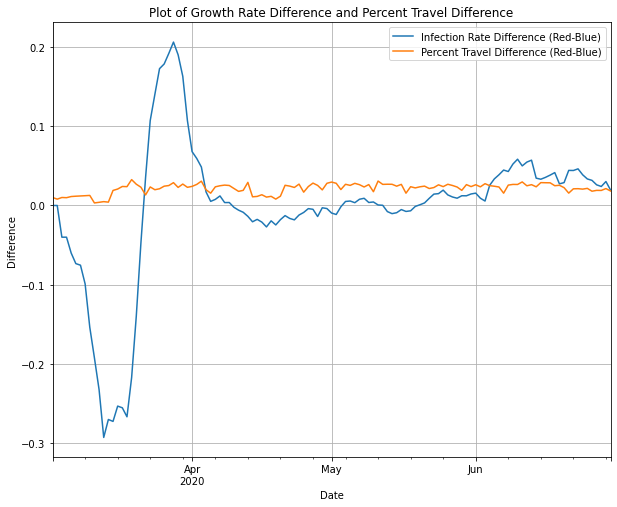

In [606]:
get_Correlations(startDate, endDate, red_blue_diff, difference_df, 'Cluster_1')

## Cluster: 3
- Blue States: ['NJ' 'IL']
- Red States: ['MI' 'NC' 'PA' 'OH' 'GA']

Calculating and Plotting Growth rate for State: NJ
Calculating and Plotting Growth rate for State: IL
Calculating and Plotting Growth rate for State: MI
Calculating and Plotting Growth rate for State: NC
Calculating and Plotting Growth rate for State: PA
Calculating and Plotting Growth rate for State: OH
Calculating and Plotting Growth rate for State: GA


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encounte

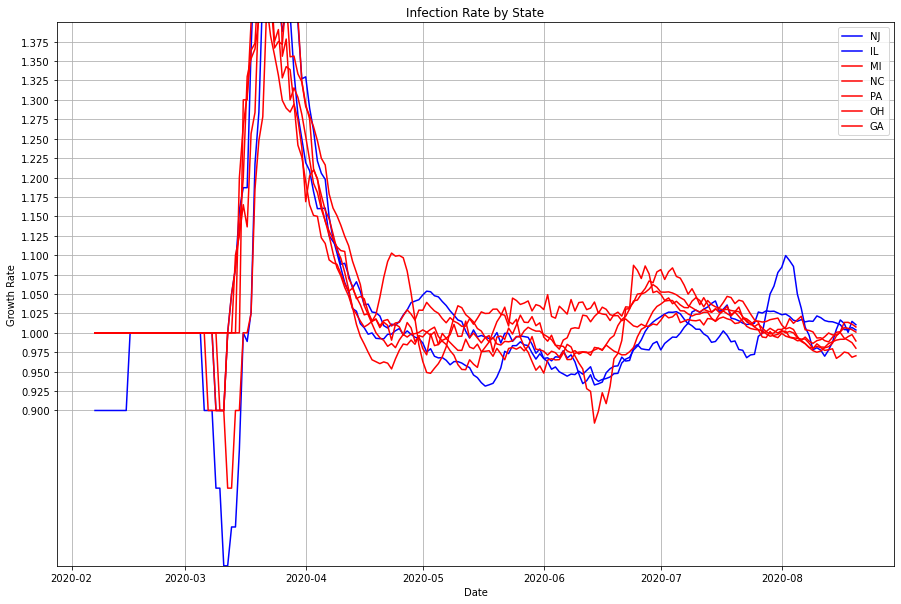

In [607]:
state_codes = ['NJ', 'IL', 'MI', 'NC', 'PA', 'OH', 'GA']
diffList_dict, growthRate_dict = stateInfectionRate(state_codes)

In [608]:
#Get the mean of all blue and all red states in Cluster
mean_blue =  (State_Cases_7Day_Avg.Growth_NJ + State_Cases_7Day_Avg.Growth_IL)/2
mean_red = (State_Cases_7Day_Avg.Growth_MI + State_Cases_7Day_Avg.Growth_NC + State_Cases_7Day_Avg.Growth_PA + 
           State_Cases_7Day_Avg.Growth_OH + State_Cases_7Day_Avg.Growth_GA)/5

red_blue_diff_3 = mean_red - mean_blue

In [626]:
#Specify date range for correlations
startDate = '2020-02-01'
endDate = '2020-07-20'

Pearson Correlation: (-0.31085926211068104, 3.896011634107511e-05)


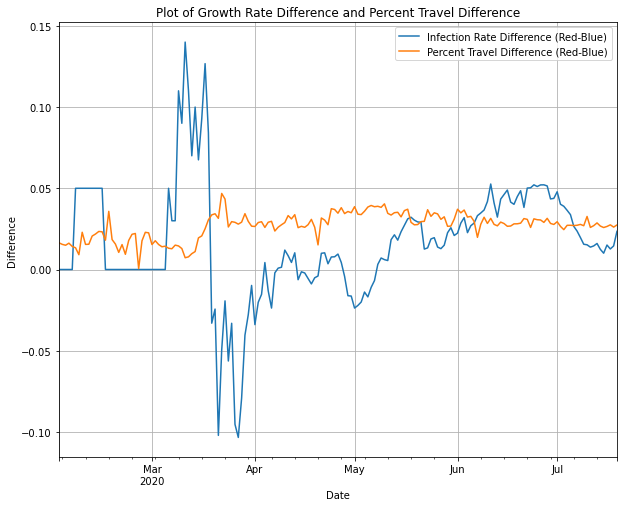

In [627]:
get_Correlations(startDate, endDate, red_blue_diff_3, difference_df, 'Cluster_3')

## Cluster: 5
- Blue States:['NM' 'NV' 'OR']
- Red States: ['SD' 'AK' 'ND' 'NE' 'KS' 'MT' 'WY' 'UT' 'ID']

Calculating and Plotting Growth rate for State: NM
Calculating and Plotting Growth rate for State: NV
Calculating and Plotting Growth rate for State: OR
Calculating and Plotting Growth rate for State: SD
Calculating and Plotting Growth rate for State: AK
Calculating and Plotting Growth rate for State: ND
Calculating and Plotting Growth rate for State: NE
Calculating and Plotting Growth rate for State: KS
Calculating and Plotting Growth rate for State: MT
Calculating and Plotting Growth rate for State: WY
Calculating and Plotting Growth rate for State: UT


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encounte

Calculating and Plotting Growth rate for State: ID


C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\kvomb\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in long_scalars


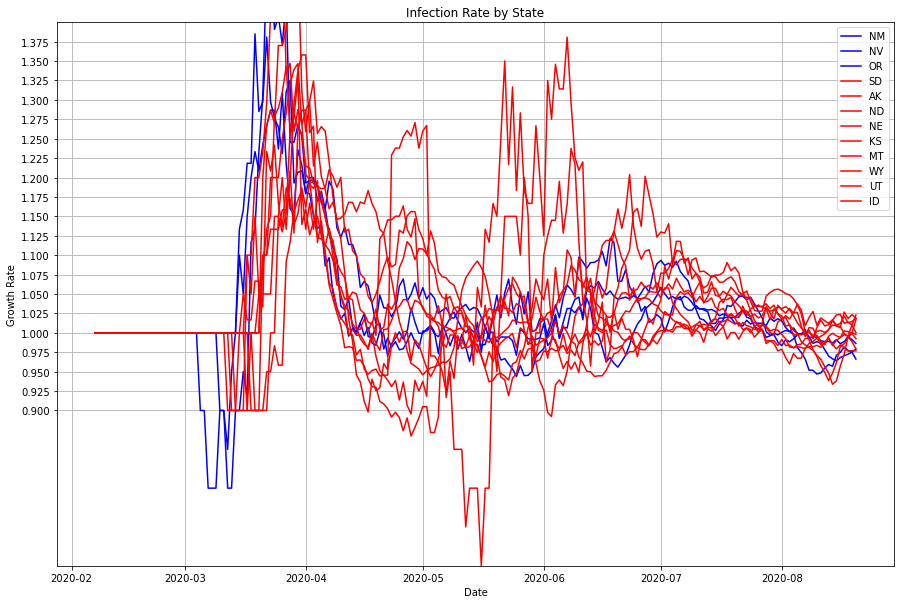

In [613]:
state_codes = ['NM','NV', 'OR', 'SD', 'AK', 'ND', 'NE', 'KS', 'MT', 'WY', 'UT', 'ID']
diffList_dict, growthRate_dict = stateInfectionRate(state_codes)

In [614]:
#Get the mean of all blue and all red states in Cluster
mean_blue =  (State_Cases_7Day_Avg.Growth_NM + State_Cases_7Day_Avg.Growth_NV + State_Cases_7Day_Avg.Growth_OR)/3

mean_red = (State_Cases_7Day_Avg.Growth_SD + State_Cases_7Day_Avg.Growth_AK + State_Cases_7Day_Avg.Growth_ND + 
           State_Cases_7Day_Avg.Growth_NE + State_Cases_7Day_Avg.Growth_KS + State_Cases_7Day_Avg.Growth_MT + 
           State_Cases_7Day_Avg.Growth_WY + State_Cases_7Day_Avg.Growth_UT + State_Cases_7Day_Avg.Growth_ID)/9

red_blue_diff_5 = mean_red - mean_blue

In [632]:
#Specify date range for correlations
startDate = '2020-03-15'
endDate = '2020-07-01'

Pearson Correlation: (0.30218602300325687, 0.001559260110485607)


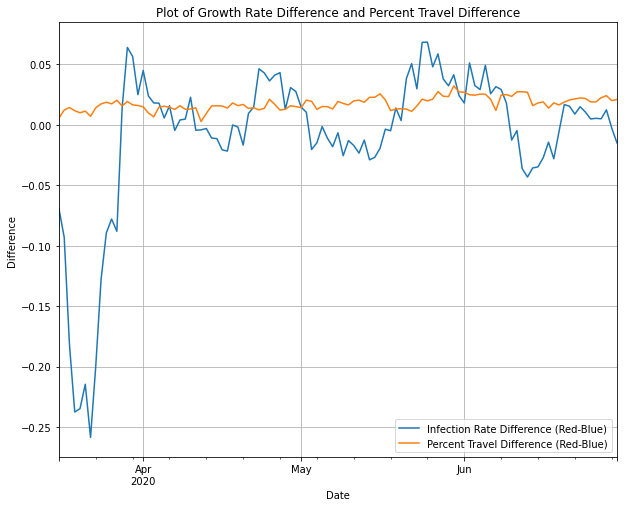

In [633]:
get_Correlations(startDate, endDate, red_blue_diff_5, difference_df, 'Cluster_5')

In [644]:
## New cluster results
cluster_list = pd.read_csv("state_cluster_result.csv")

In [650]:
cluster_list.loc[cluster_list.State.isin(TRUMP_2016_STATES), 'RED_FLAG'] = 1
cluster_list.loc[cluster_list.State.isin(HILLARY_2016_STATES), 'RED_FLAG'] = 0

In [651]:
cluster_list[cluster_list['cluster']==1]

State  cluster  RED_FLAG
7     FL        1       1.0
8     GA        1       1.0
11    IL        1       0.0
20    MI        1       1.0
28    NJ        1       0.0
30    NY        1       0.0
31    NC        1       1.0
33    OH        1       1.0
36    PA        1       1.0
44    VA        1       0.0

## Initial Work - Key States Analysis